# This code estimates medical visits and transportation needs across the state of Kentucky using specific rates derived from the NHTS dataset through a cross-classification modeling approach.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import census 
from census import Census
from us import states
c = Census("4049ee84e96e784c0042da45d81f95514d53b7fd")

### Load data (Trip Data, NHTS )

In [2]:
# Load data (NHTS Data)
trips = pd.read_csv('trippub.csv')

In [3]:
trips

,HOUSEID,PERSONID,TDTRPNUM,STRTTIME,ENDTIME,TRVLCMIN,TRPMILES,TRPTRANS,TRPACCMP,TRPHHACC,...,OBHTNRNT,OBPPOPDN,OBRESDN,DTHTNRNT,DTPPOPDN,DTRESDN,DTEEMPDN,DBHTNRNT,DBPPOPDN,DBRESDN
0,30000007,1,1,1000,1015,15,5.244,3,0,0,...,20,750,300,50,750,300,350,30,300,300
1,30000007,1,2,1510,1530,20,5.149,3,0,0,...,30,300,300,50,1500,750,750,20,750,300
2,30000007,2,1,700,900,120,84.004,6,0,0,...,40,1500,750,50,1500,750,750,20,750,300
3,30000007,2,2,1800,2030,150,81.628,6,0,0,...,20,750,300,40,1500,750,750,40,1500,750
4,30000007,3,1,845,900,15,2.250,3,0,0,...,20,750,300,50,750,300,350,60,750,300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
923567,50515573,1,1,810,837,27,1.168,1,0,0,...,70,30000,17000,70,7000,7000,5000,80,17000,17000
923568,50515573,1,2,1320,1328,8,0.238,1,0,0,...,80,17000,17000,70,7000,7000,5000,60,3000,3000
923569,50515573,1,3,1415,1420,5,0.238,1,0,0,...,60,3000,3000,70,7000,7000,5000,80,17000,17000
923570,50515573,1,4,1820,1845,25,0.867,1,0,0,...,80,17000,17000,60,30000,30000,5000,70,30000,30000


### Load data (Person attribute, NHTS)

In [4]:
# Load data (Person attribute NHTS)
pers = pd.read_csv('perpub.csv')

In [5]:
pers

,HOUSEID,PERSONID,R_AGE,EDUC,R_HISP,R_RELAT,R_SEX,R_RACE,PRMACT,PAYPROF,...,SMPLSRCE,WTPERFIN,HBHUR,HTHTNRNT,HTPPOPDN,HTRESDN,HTEEMPDN,HBHTNRNT,HBPPOPDN,HBRESDN
0,30000007,1,67,3,2,1,2,2,6,2,...,2,206.690153,T,50,1500,750,750,20,750,300
1,30000007,2,66,3,2,2,1,2,1,-1,...,2,197.075742,T,50,1500,750,750,20,750,300
2,30000007,3,28,2,2,3,2,2,5,2,...,2,219.514210,T,50,1500,750,750,20,750,300
3,30000008,1,55,5,2,1,1,1,1,-1,...,2,63.185911,R,5,300,300,150,5,300,300
4,30000008,2,49,4,2,2,2,1,1,-1,...,2,58.665911,R,5,300,300,150,5,300,300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264229,40794301,4,18,2,2,3,2,1,97,2,...,2,213.514657,R,20,50,50,25,20,300,50
264230,40794301,5,14,1,2,3,2,1,-1,-1,...,2,133.448420,R,20,50,50,25,20,300,50
264231,40794301,6,12,-1,2,3,2,1,-1,-1,...,2,133.448420,R,20,50,50,25,20,300,50
264232,40794301,7,8,-1,2,3,2,1,-1,-1,...,2,133.448420,R,20,50,50,25,20,300,50


### Add a new column for medical trips

In [6]:
# Add a new column for medical trips
trips['Medical_Visits'] = trips['WHYTRP1S'].apply(lambda x: 1 if x == 30 else 0)

## Create Time Bin for Travel Time

In [7]:
trips[['TRVLCMIN', 'TRPMILES', 'Medical_Visits']]

,TRVLCMIN,TRPMILES,Medical_Visits
0,15,5.244,0
1,20,5.149,0
2,120,84.004,0
3,150,81.628,0
4,15,2.250,0
...,...,...,...
923567,27,1.168,0
923568,8,0.238,0
923569,5,0.238,0
923570,25,0.867,0


In [8]:
medical_survey = trips['Medical_Visits'].value_counts()

# Visualize medical visit survey

In [9]:
medical_survey

Medical_Visits
0    906788
1     16784
Name: count, dtype: int64

In [10]:
# Convert to dataFrame
medical_survey = pd.DataFrame(medical_survey)

medical_survey

,count
Medical_Visits,
0,906788
1,16784


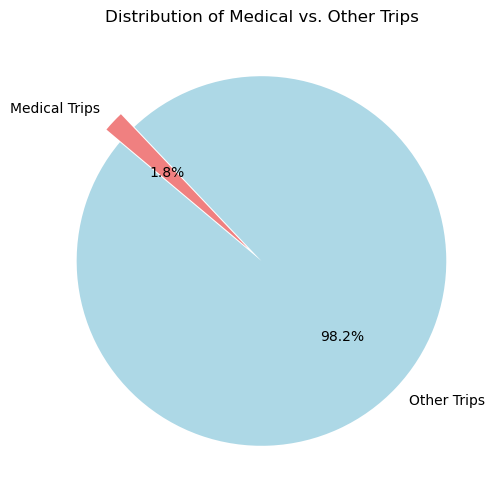

In [11]:
import matplotlib.pyplot as plt

# Data
labels = ['Other Trips', 'Medical Trips']
sizes = [906788, 16784]  # Counts
colors = ['lightblue', 'lightcoral']  # Custom colors
explode = (0, 0.1)  # Slightly explode the Medical Trips slice

# Create pie chart
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, explode=explode, startangle=140)
plt.title('Distribution of Medical vs. Other Trips')
plt.show()


In [12]:
# Define the bin edges
bin_edges = list(range(0, 300, 10))  

# Create labels for the bins
bin_labels = [f"{bin_edges[i]}-{bin_edges[i+1]}" for i in range(len(bin_edges)-1)]

# Assign each TRVLCMIN value to a bin
trips["Time Bin"] = pd.cut(trips["TRVLCMIN"], bins=bin_edges, labels=bin_labels, right=False)

# Group by the Time Bin and sum the corresponding Medical_Visits
time_bin_summary = trips.groupby("Time Bin")["Medical_Visits"].sum().reset_index()

# Rename the columns
time_bin_summary.columns = ["Time Bin", "Total Medical Visits"]

time_bin_summary

,Time Bin,Total Medical Visits
0,0-10,2334
1,10-20,5919
2,20-30,2856
3,30-40,2663
4,40-50,1056
5,50-60,416
6,60-70,636
7,70-80,227
8,80-90,88
9,90-100,182


In [13]:
# Calculate the cumulative sum of Total Medical Visits
time_bin_summary['Cumulative Total Medical Visits'] = time_bin_summary['Total Medical Visits'].cumsum()

# Calculating Total Cumulative Sum
total_cumulative_sum = time_bin_summary["Cumulative Total Medical Visits"].iloc[-1]

# Adding Rate Column
time_bin_summary["% of Visit"] = (time_bin_summary["Total Medical Visits"] / total_cumulative_sum) * 100

time_bin_summary

,Time Bin,Total Medical Visits,Cumulative Total Medical Visits,% of Visit
0,0-10,2334,2334,13.941819
1,10-20,5919,8253,35.356311
2,20-30,2856,11109,17.059913
3,30-40,2663,13772,15.907055
4,40-50,1056,14828,6.307867
5,50-60,416,15244,2.484917
6,60-70,636,15880,3.799056
7,70-80,227,16107,1.355952
8,80-90,88,16195,0.525656
9,90-100,182,16377,1.087151


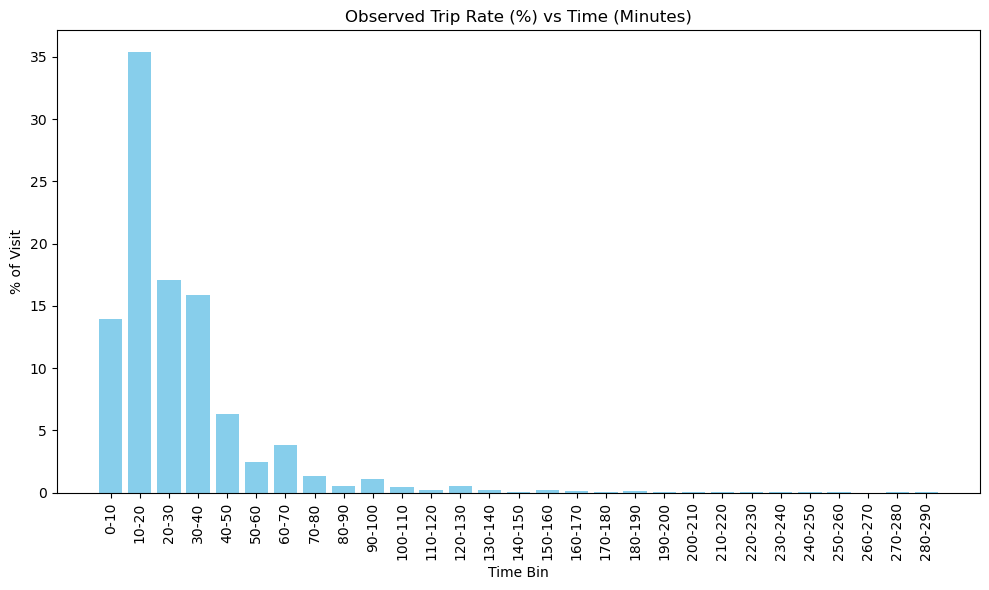

In [14]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(time_bin_summary['Time Bin'], time_bin_summary['% of Visit'], color='skyblue')
plt.xticks(rotation=90)  # Rotate the time bins to make them readable
plt.xlabel('Time Bin')
plt.ylabel('% of Visit')
plt.title('Observed Trip Rate (%) vs Time (Minutes)')
plt.tight_layout()
plt.show()


In [15]:
## Save data
time_bin_summary.to_csv("NHTS_Time_bin.csv", index=False)

In [16]:
# Ensure "Time Bin" is treated as a string
time_bin_summary["Time Bin"] = time_bin_summary["Time Bin"].astype(str)

# Calculate midpoints of each time bin
time_bin_summary["Midpoint"] = time_bin_summary["Time Bin"].apply(lambda x: np.mean([int(i) for i in x.split('-')]))

# Compute weighted average travel time
average_travel_time = (time_bin_summary["Midpoint"] * time_bin_summary["Total Medical Visits"]).sum() / time_bin_summary["Total Medical Visits"].sum()

print(f"Average Travel Time: {average_travel_time:.2f} minutes")


Average Travel Time: 28.18 minutes


## Create Distance Bin for Distance

In [17]:
trips[['TRVLCMIN', 'TRPMILES', 'Medical_Visits']]

,TRVLCMIN,TRPMILES,Medical_Visits
0,15,5.244,0
1,20,5.149,0
2,120,84.004,0
3,150,81.628,0
4,15,2.250,0
...,...,...,...
923567,27,1.168,0
923568,8,0.238,0
923569,5,0.238,0
923570,25,0.867,0


In [18]:
# Define the bin edges 
bin_edges = list(range(0, 90, 2))  

# Create labels for the bins
bin_labels = [f"{bin_edges[i]}-{bin_edges[i+1]}" for i in range(len(bin_edges)-1)]

# Assign each TRVLCMIN value to a bin
trips["Distance Bin"] = pd.cut(trips["TRPMILES"], bins=bin_edges, labels=bin_labels, right=False)

# Group by the Time Bin and sum the corresponding Medical_Visits
dist_bin_summary = trips.groupby("Distance Bin")["Medical_Visits"].sum().reset_index()

# Rename the columns
dist_bin_summary.columns = ["Distance Bin", "Total Medical Visits"]

dist_bin_summary

,Distance Bin,Total Medical Visits
0,0-2,3362
1,2-4,3053
2,4-6,2205
3,6-8,1560
4,8-10,1234
5,10-12,898
6,12-14,659
7,14-16,574
8,16-18,509
9,18-20,429


In [19]:
# Calculate the cumulative sum of Total Medical Visits
dist_bin_summary['Cumulative Total Medical Visits'] = dist_bin_summary['Total Medical Visits'].cumsum()

# Calculating Total Cumulative Sum
total_cumulative_sum = dist_bin_summary["Cumulative Total Medical Visits"].iloc[-1]

# Adding Rate Column
dist_bin_summary["Visit Rate (%)"] = (dist_bin_summary["Total Medical Visits"] / total_cumulative_sum) * 100

dist_bin_summary

,Distance Bin,Total Medical Visits,Cumulative Total Medical Visits,Visit Rate (%)
0,0-2,3362,3362,20.229857
1,2-4,3053,6415,18.370540
2,4-6,2205,8620,13.267946
3,6-8,1560,10180,9.386846
4,8-10,1234,11414,7.425236
5,10-12,898,12312,5.403454
6,12-14,659,12971,3.965341
7,14-16,574,13545,3.453878
8,16-18,509,14054,3.062759
9,18-20,429,14483,2.581383


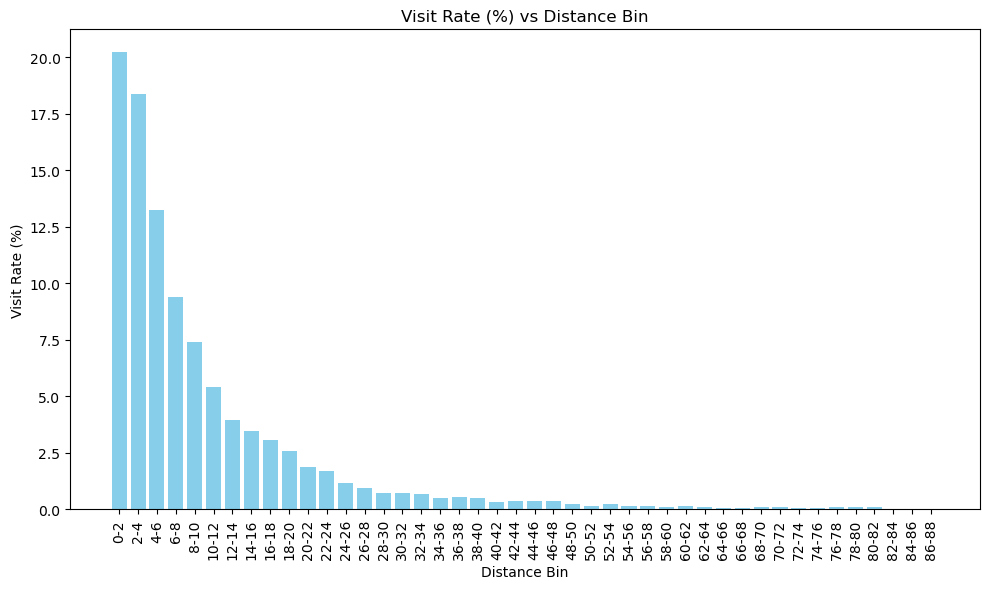

In [20]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(dist_bin_summary['Distance Bin'], dist_bin_summary['Visit Rate (%)'], color='skyblue')
plt.xticks(rotation=90)  # Rotate the time bins to make them readable
plt.xlabel('Distance Bin')
plt.ylabel('Visit Rate (%)')
plt.title('Visit Rate (%) vs Distance Bin')
plt.tight_layout()
plt.show()


In [21]:
# Ensure "Time Bin" is treated as a string
dist_bin_summary["Distance Bin"] = dist_bin_summary["Distance Bin"].astype(str)

# Calculate midpoints of each time bin
dist_bin_summary["Midpoint"] = dist_bin_summary["Distance Bin"].apply(lambda x: np.mean([int(i) for i in x.split('-')]))

# Compute weighted average travel time
average_travel_distance = (dist_bin_summary["Midpoint"] * dist_bin_summary["Total Medical Visits"]).sum() / dist_bin_summary["Total Medical Visits"].sum()

print(f"Average Travel Distance: {average_travel_distance:.2f} miles")


Average Travel Distance: 9.87 miles


In [22]:
## Save data
dist_bin_summary.to_csv("NHTS_Distance_bin.csv", index=False)

In [23]:
dist_bin_summary

,Distance Bin,Total Medical Visits,Cumulative Total Medical Visits,Visit Rate (%),Midpoint
0,0-2,3362,3362,20.229857,1.0
1,2-4,3053,6415,18.370540,3.0
2,4-6,2205,8620,13.267946,5.0
3,6-8,1560,10180,9.386846,7.0
4,8-10,1234,11414,7.425236,9.0
5,10-12,898,12312,5.403454,11.0
6,12-14,659,12971,3.965341,13.0
7,14-16,574,13545,3.453878,15.0
8,16-18,509,14054,3.062759,17.0
9,18-20,429,14483,2.581383,19.0


In [24]:
trips['TRVLCMIN'].max()

1200

### Group by Household_ID and Person_ID to count the number of medical trips for each person

In [25]:
# Group by Household_ID and Person_ID to count the number of medical trips for each person
medical_visit_counts = trips.groupby(['HOUSEID', 'PERSONID'])['Medical_Visits'].sum().reset_index()

In [26]:
medical_visit_counts

,HOUSEID,PERSONID,Medical_Visits
0,30000007,1,0
1,30000007,2,0
2,30000007,3,0
3,30000008,1,0
4,30000012,1,0
...,...,...,...
219189,40794293,2,0
219190,40794301,2,0
219191,40794301,3,0
219192,40794301,6,0


In [27]:
medical_visit_counts['Medical_Visits'].sum()

16784

### Merge the Medical Visit to the person dataset

In [28]:
# Merge the Medical Visit to the person dataset
pers = pers.merge(medical_visit_counts, on=['HOUSEID', 'PERSONID'])

In [29]:
pers['Medical_Visits']

0         0
1         0
2         0
3         0
4         0
         ..
219189    0
219190    0
219191    0
219192    0
219193    0
Name: Medical_Visits, Length: 219194, dtype: int64

In [30]:
pers['Medical_Visits'].sum()

16784

In [31]:
unique_in_dx = set(pers['Medical_Visits']) - set(medical_visit_counts["Medical_Visits"])
unique_in_dx

set()

### Define age groups

In [32]:
# Define age groups
# Definition: 
'''
5-18 = Children
18-35 = Young Adults
35-50 = Middle Adults
50-65 = Older Adults
65-80 = Seniors
80-92 = Elderly

'''
bins_age = [5, 18, 35, 50, 65, 80, 93]  # Custom bins for medical trips
labels_age = ['Children', 'Young Adults', 'Middle Adults', 'Older Adults', 'Seniors', 'Elderly']
pers['Age_Group'] = pd.cut(pers['R_AGE'], bins=bins_age, labels=labels_age, right=False)

### Define income classes

In [33]:
# Define income classes

# Map codes to descriptive labels
income_mapping = {
    1: "Less than $10,000",
    2: "$10,000 to $14,999",
    3: "$15,000 to $24,999",
    4: "$25,000 to $34,999",
    5: "$35,000 to $49,999",
    6: "$50,000 to $74,999",
    7: "$75,000 to $99,999",
    8: "$100,000 to $124,999",
    9: "$125,000 to $149,999",
    10: "$150,000 to $199,999",
    11: "$200,000 or more",
    -7: "Prefer not to answer",
    -8: "I don't know",
    -9: "Not ascertained"
}

# Map the column to descriptive labels
pers['Income_Label'] = pers['HHFAMINC'].map(income_mapping)

# Define bins for income levels (only for numeric ranges)
bins_income = [-float('inf'), 3, 6, float('inf')]  # Bin edges: <25K, 25-75K, >75K
labels_income = ['Low Income', 'Middle Income', 'High Income']

# Apply bins only to numeric income values
numeric_income = pers['HHFAMINC'].where(pers['HHFAMINC'] > 0)  # Exclude special codes
pers['Income_Category'] = pd.cut(numeric_income, bins=bins_income, labels=labels_income, right=False)

### Define Racial Categories

In [34]:
# Define Racial Categories
# Map codes to descriptive labels
race_mapping = {
    1: "White",
    2: "Black or African American",
    3: "Asian",
    4: "American Indian or Alaska Native",
    5: "Native Hawaiian or Other Pacific Islander",
    6: "Multiple Responses Selected",
    97: "Some Other Race",
    -7: "Refused",
    -8: "Don't Know"
}

# Map the column to descriptive labels
pers['Race_Label'] = pers['HH_RACE'].map(race_mapping)

# Define broader categories for grouped analysis
group_mapping = {
    "White": "White",
    "Black or African American": "Minority",
    "Asian": "Minority",
    "American Indian or Alaska Native": "Minority",
    "Native Hawaiian or Other Pacific Islander": "Minority",
    "Multiple Responses Selected": "Unknown",
    "Some Other Race": "Unknown",
    "Refused": "Unknown",
    "Don't Know": "Unknown"
}

# Map the Race_Label to broader categories
pers['Race_Group'] = pers['Race_Label'].map(group_mapping)

### Define Gender Categories

In [35]:
# Define Gender Categories
# Map codes to descriptive labels
sex_mapping = {
    1: "Male",
    2: "Female",
    -7: "Prefer not to answer",
    -8: "I don't know"
}

# Map the column to descriptive labels
pers['Sex_Label'] = pers['R_SEX'].map(sex_mapping)

group_mapping1 = {
    "Male": "Male",
    "Female": "Female",
    "Prefer not to answer": "Unknown",
    "I don't know": "Unknown"
}

pers['Gender_Group'] = pers['Sex_Label'].map(group_mapping1)

### Define Urban-Rural Indicator

In [36]:
# Map codes to descriptive labels
Location_mapping = {
    1: "Urban",
    2: "Rural",
}

# Map the column to descriptive labels
pers['Locality_Group'] = pers['URBRUR'].map(Location_mapping)

## Analyze Share of people who needs ride

### Define CONDRIDE: Medical condition results in asking others for ride

In [37]:
# Define CONDRIDE Categories: Medical Condition Results in Asking Others for Rides
# Map codes to descriptive labels
mapping = {
    1: "Yes",
    2: "No",
    -1: "Appropriate skip",
    -9: "Not ascertained"
}

# Map the column to descriptive labels
pers['condride_Label'] = pers['CONDRIDE'].map(mapping)

group_mapping2 = {
    "Yes": "Yes",
    "No": "No",
    "Appropriate skip": "Unknown",
    "Not ascertained": "Unknown"
}

pers['Cond_ride'] = pers['condride_Label'].map(group_mapping2)

### Define CONDRIVE: Medical condition results in giving up driving

In [38]:
# Define CONDRIVE Categories:Medical Condition Results in Giving up Driving
# Map codes to descriptive labels
con_mapping = {
    1: "Yes",
    2: "No",
    -1: "Appropriate skip",
    -9: "Not ascertained"
}

# Map the column to descriptive labels
pers['condrive_Label'] = pers['CONDRIVE'].map(con_mapping)

group_mapping3 = {
    "Yes": "Yes",
    "No": "No",
    "Appropriate skip": "Unknown",
    "Not ascertained": "Unknown"
}

pers['Cond_drive'] = pers['condrive_Label'].map(group_mapping3)

### Define DRIVER status

In [39]:
# Define DRIVER Categories
# Map codes to descriptive labels
drive_mapping = {
    1: "Yes",
    2: "No",
    -1: "Appropriate skip"
}

# Map the column to descriptive labels
pers['driver_Label'] = pers['DRIVER'].map(drive_mapping)

group_mapping4 = {
    "Yes": "Yes",
    "No": "No",
    "Appropriate skip": "Unknown"
}

pers['driver_status'] = pers['driver_Label'].map(group_mapping4)

## Define Alternative Transport means (Public Transportation or Taxi)

In [40]:
# Define Alternative driving
# Map codes to descriptive labels
alt1_mapping = {
    -9: "Not ascertained",
    -1: "Appropriate skip",
    1: "Public transportation",
    2: "Taxi",
    3: "Both", 
    4: "Neither"
}

# Map the column to descriptive labels
pers['pubtaxi'] = pers['ALT_16'].map(alt1_mapping)

group_mapping5 = {
    "Public transportation": "Public transportation",
    "Taxi": "Taxi",
    "Both": "Both",
    "Neither": "Neither",
    "Appropriate skip": "Unknown",
    "Not ascertained": "Unknown"
}

pers['public_Taxi'] = pers['pubtaxi'].map(group_mapping5)

## Define Alternative Transport means (Passenger to Friend/Family Member or Rental Car)

In [41]:
# Define Alternative driving
# Map codes to descriptive labels
alt2_mapping = {
    -9: "Not ascertained",
    -1: "Appropriate skip",
    1: "Family/Friend",
    2: "Rental",
    3: "Both", 
    4: "Neither"
}


# Map the column to descriptive labels
pers['frnd_rent'] = pers['ALT_23'].map(alt2_mapping)

group_mapping6 = {
    "Family/Friend": "Family/Friend",
    "Rental": "Rental",
    "Both": "Both",
    "Neither": "Neither",
    "Appropriate skip": "Unknown",
    "Not ascertained": "Unknown"
}

pers['Friend_rental_transport'] = pers['frnd_rent'].map(group_mapping6)

### Define the conditions for persons who need a ride

In [42]:
pers['CONDRIVE'].value_counts()

CONDRIVE
-1    196801
 2     19287
 1      3094
-9        12
Name: count, dtype: int64

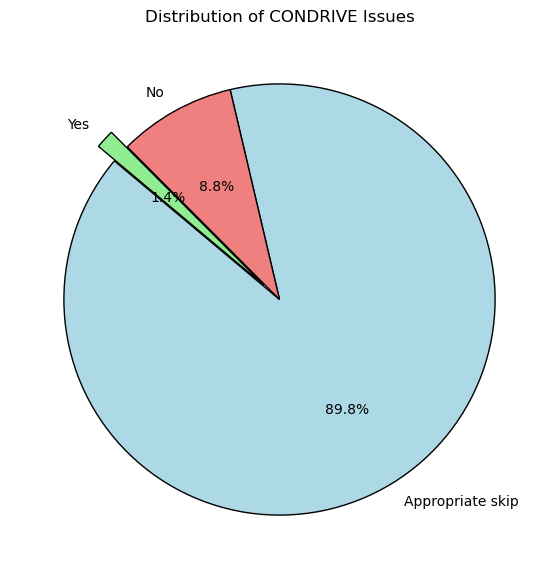

In [43]:
import matplotlib.pyplot as plt

# Data
labels = ['Appropriate skip', 'No', 'Yes']
sizes = [196801, 19287, 3094]  # Counts
colors = ['lightblue', 'lightcoral', 'lightgreen']  # Enough colors
explode = (0, 0, 0.1)  # Slightly explode all slices for spacing

# Create pie chart
plt.figure(figsize=(7,7))  # Slightly larger figure for better readability
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, explode=explode, 
        startangle=140, wedgeprops={'edgecolor': 'black', 'linewidth': 1})

plt.title('Distribution of CONDRIVE Issues')
plt.show()

In [44]:
pers['CONDRIDE'].value_counts()

CONDRIDE
-1    196801
 2     15508
 1      6873
-9        12
Name: count, dtype: int64

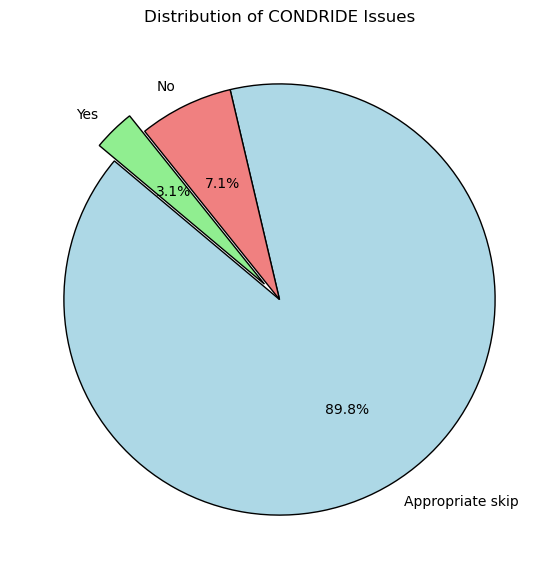

In [45]:
import matplotlib.pyplot as plt

# Data
labels = ['Appropriate skip', 'No', 'Yes']
sizes = [196801, 15508, 6873]  # Counts
colors = ['lightblue', 'lightcoral', 'lightgreen']  # Enough colors
explode = (0, 0, 0.1)  # Slightly explode all slices for spacing

# Create pie chart
plt.figure(figsize=(7,7))  # Slightly larger figure for better readability
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, explode=explode, 
        startangle=140, wedgeprops={'edgecolor': 'black', 'linewidth': 1})

plt.title('Distribution of CONDRIDE Issues')
plt.show()

In [46]:
pers['DRIVER'].value_counts()

DRIVER
 1    184312
-1     21119
 2     13763
Name: count, dtype: int64

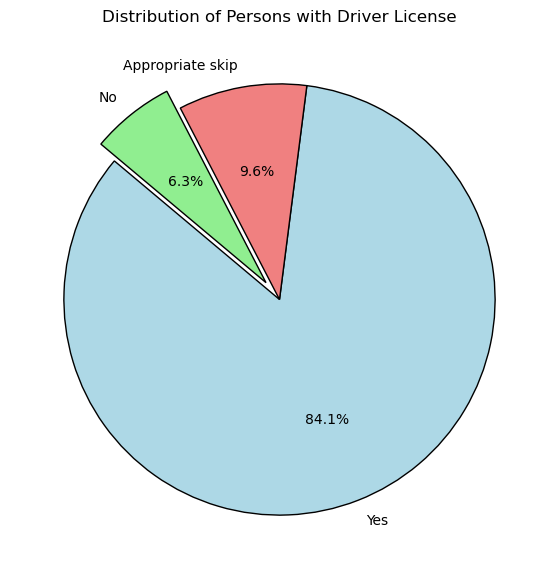

In [47]:
import matplotlib.pyplot as plt

# Data
labels = ['Yes', 'Appropriate skip', 'No']
sizes = [184312, 21119, 13763]  # Counts
colors = ['lightblue', 'lightcoral', 'lightgreen']  # Enough colors
explode = (0, 0, 0.1)  # Slightly explode all slices for spacing

# Create pie chart
plt.figure(figsize=(7,7))  # Slightly larger figure for better readability
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, explode=explode, 
        startangle=140, wedgeprops={'edgecolor': 'black', 'linewidth': 1})

plt.title('Distribution of Persons with Driver License')
plt.show()

In [48]:
pers['HHVEHCNT'].value_counts()

HHVEHCNT
2     93750
1     47806
3     43703
4     17725
0      6230
5      6198
6      2252
7       840
8       336
9       166
10       77
12       72
11       39
Name: count, dtype: int64

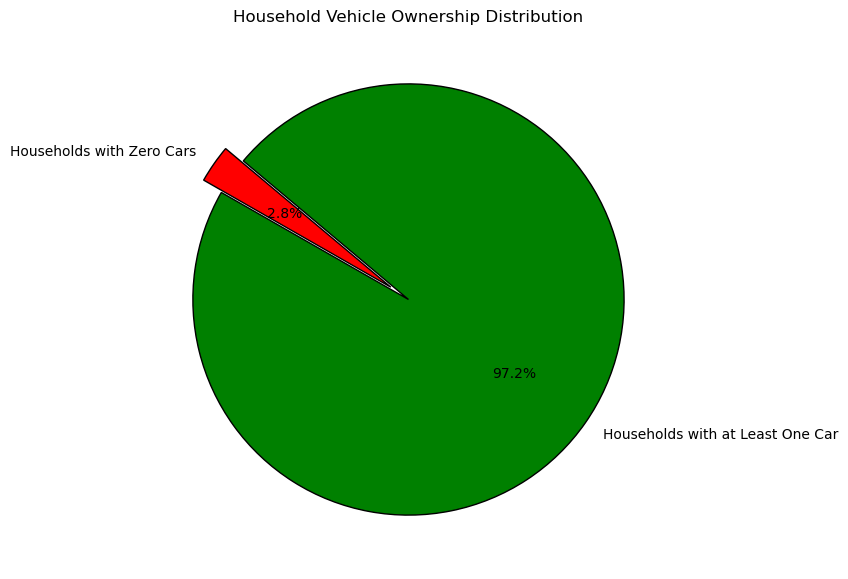

In [49]:
import matplotlib.pyplot as plt

# Data
labels = ['Households with Zero Cars', 'Households with at Least One Car']
sizes = [6230, 93750 + 47806 + 43703 + 17725 + 6198 + 2252 + 840 + 336 + 166 + 77 + 72 + 39]  # Summing non-zero HHVEHCNT values
colors = ['red', 'green']  # Red for zero cars, green for others
explode = (0.1, 0)  # Slightly explode the zero-car category for emphasis

# Create pie chart
plt.figure(figsize=(7,7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, explode=explode, 
        startangle=140, wedgeprops={'edgecolor': 'black', 'linewidth': 1})

plt.title('Household Vehicle Ownership Distribution')
plt.show()


In [50]:
# Define the conditions
pers['Need_ride'] = np.where(
    ((pers['CONDRIVE'] == 1) | 
     (pers['CONDRIDE'] == 1) | 
     (pers['DRIVER'] == 2) | 
     (pers['HHVEHCNT'] == 0)),  
    1, 0
)

In [51]:
pers['Need_ride'].value_counts()

Need_ride
0    198816
1     20378
Name: count, dtype: int64

### Define the condition for people who need a medical ride

In [52]:
pers['Need_med_ride'] = np.where(
    ((pers['CONDRIVE'] == 1) | 
     (pers['CONDRIDE'] == 1) | 
     (pers['DRIVER'] == 2) | 
     (pers['HHVEHCNT'] == 0))  # Grouped OR conditions
    & (pers['Medical_Visits'] != 0),  # AND applies correctly
    1, 0
)

In [53]:
pers['Need_med_ride'].value_counts()

Need_med_ride
0    216683
1      2511
Name: count, dtype: int64

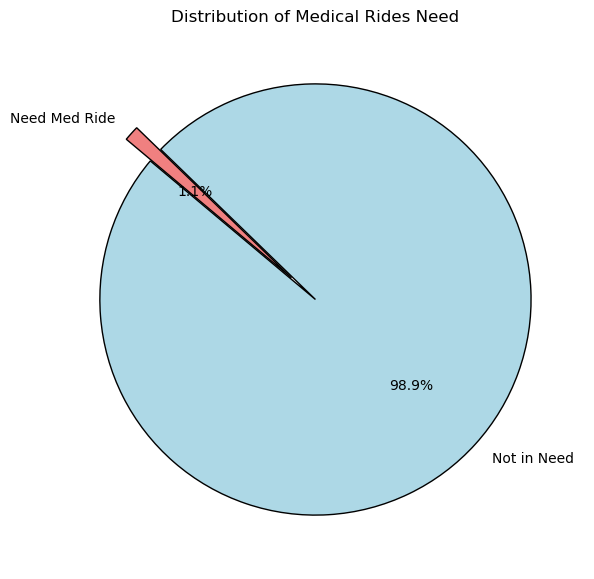

In [54]:
# Data
labels = ['Not in Need', 'Need Med Ride']
sizes = [216683, 2511]  # Counts
colors = ['lightblue', 'lightcoral']  # Enough colors
explode = (0, 0.15)  # Slightly explode all slices for spacing

# Create pie chart
plt.figure(figsize=(7,7))  # Slightly larger figure for better readability
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, explode=explode, 
        startangle=140, wedgeprops={'edgecolor': 'black', 'linewidth': 1})

plt.title('Distribution of Medical Rides Need')
plt.show()


## Remove rows with "Unknown" in Gender_Group since it's very small in the dataset

In [55]:
# Remove rows with "Unknown" in Gender_Group
pers_filter = pers[pers['Gender_Group'] != 'Unknown']

### Aggregate data by Urban-Rural only

In [56]:
# Aggregate data by Urban-Rural
pers_agg_rural = pers_filter.groupby(['Locality_Group']).agg(
    Total_Medical_Visits=('Medical_Visits', 'sum'),  # Sum of medical trips
    Min_Medical_Visits=('Medical_Visits', 'min'),  # Minimum medical trips
    Max_Medical_Visits=('Medical_Visits', 'max'),  # Maximum medical trips
    Avg_Medical_Visits=('Medical_Visits', 'mean'),  # Average medical trips
    Average_Age=('R_AGE', 'mean'),           # Average age
    Total_Need_ride=('Need_ride', 'sum'),  # Sum of persons who need ride
    Need_med_ride_Total=('Need_med_ride', 'sum'),  # Sum of persons who need medical ride
    Person_Count=('PERSONID', 'count')            # Number of persons
).reset_index()

In [57]:
pers_agg_rural

,Locality_Group,Total_Medical_Visits,Min_Medical_Visits,Max_Medical_Visits,Avg_Medical_Visits,Average_Age,Total_Need_ride,Need_med_ride_Total,Person_Count
0,Rural,4039,0,4,0.082897,50.677832,3187,491,48723
1,Urban,12739,0,8,0.074809,47.055143,17161,2020,170286


### Calculate the rates

In [58]:
# Create a medical visit rate column
pers_agg_rural['medical_visit_rate'] = pers_agg_rural['Total_Medical_Visits']/pers_agg_rural['Person_Count']
# Create a Need ride rate column
pers_agg_rural['Need_ride_rate'] = pers_agg_rural['Total_Need_ride']/pers_agg_rural['Person_Count']
# Create a Need medical ride rate column
pers_agg_rural['Need_Medical_ride_rate'] = pers_agg_rural['Need_med_ride_Total']/pers_agg_rural['Total_Medical_Visits']

In [59]:
pers_agg_rural

,Locality_Group,Total_Medical_Visits,Min_Medical_Visits,Max_Medical_Visits,Avg_Medical_Visits,Average_Age,Total_Need_ride,Need_med_ride_Total,Person_Count,medical_visit_rate,Need_ride_rate,Need_Medical_ride_rate
0,Rural,4039,0,4,0.082897,50.677832,3187,491,48723,0.082897,0.065411,0.121565
1,Urban,12739,0,8,0.074809,47.055143,17161,2020,170286,0.074809,0.100778,0.158568


### visualize

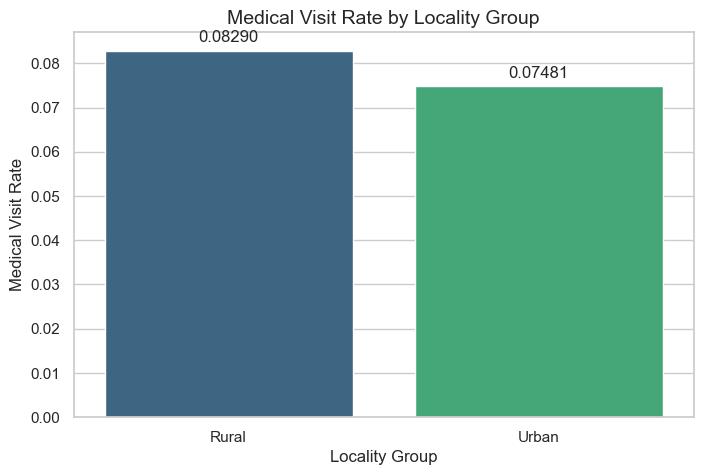

In [60]:
# Setting the visual style
sns.set_theme(style="whitegrid")

# Creating the bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x="Locality_Group", y="medical_visit_rate", data=pers_agg_rural, palette="viridis")

# Adding labels and title
plt.xlabel("Locality Group", fontsize=12)
plt.ylabel("Medical Visit Rate", fontsize=12)
plt.title("Medical Visit Rate by Locality Group", fontsize=14)

# Displaying the values on top of bars
for index, value in enumerate(pers_agg_rural["medical_visit_rate"]):
    plt.text(index, value + 0.002, f'{value:.5f}', ha='center', fontsize=12)

# Show the plot
plt.show()

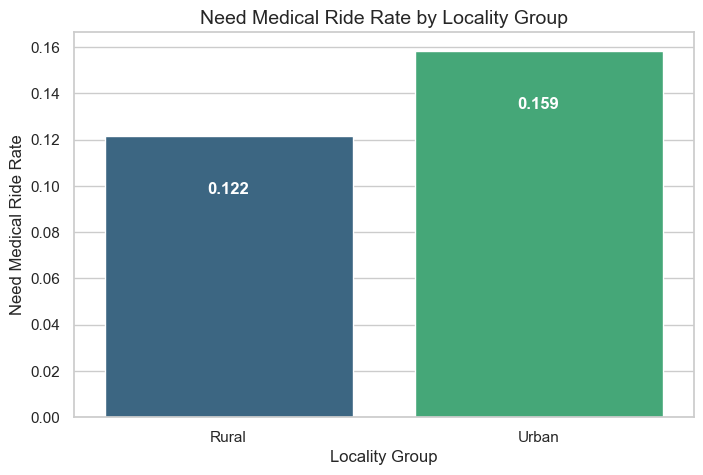

In [61]:
# Setting the visual style
sns.set_theme(style="whitegrid")

# Creating the bar plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(x="Locality_Group", y="Need_Medical_ride_rate", data=pers_agg_rural, palette="viridis")

# Adding labels and title
plt.xlabel("Locality Group", fontsize=12)
plt.ylabel("Need Medical Ride Rate", fontsize=12)
plt.title("Need Medical Ride Rate by Locality Group", fontsize=14)

# Displaying the values on the bars without overlapping the title
for bar in ax.patches:
    ax.annotate(f'{bar.get_height():.3f}', 
                (bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.02),  # Placing text slightly below the top
                ha='center', va='top', fontsize=12, color='white', fontweight='bold')

# Show the plot
plt.show()


### Aggregate data by Urban-Rural and Age 

In [62]:
# Aggregate data by Age and Gender
pers_agg_rural_age = pers_filter.groupby(['Locality_Group', 'Age_Group']).agg(
    Total_Medical_Visits=('Medical_Visits', 'sum'),  # Sum of medical trips
    Min_Medical_Visits=('Medical_Visits', 'min'),  # Minimum medical trips
    Max_Medical_Visits=('Medical_Visits', 'max'),  # Maximum medical trips
    Avg_Medical_Visits=('Medical_Visits', 'mean'),  # Average medical trips
    Average_Age=('R_AGE', 'mean'),           # Average age
    Total_Need_ride=('Need_ride', 'sum'),  # Sum of persons who need ride
    Need_med_ride_Total=('Need_med_ride', 'sum'),  # Sum of persons who need medical ride
    Person_Count=('PERSONID', 'count')            # Number of persons
).reset_index()

In [63]:
pers_agg_rural_age

,Locality_Group,Age_Group,Total_Medical_Visits,Min_Medical_Visits,Max_Medical_Visits,Avg_Medical_Visits,Average_Age,Total_Need_ride,Need_med_ride_Total,Person_Count
0,Rural,Children,186,0,3,0.032370,11.144622,664,30,5746
1,Rural,Young Adults,244,0,3,0.042958,26.668486,372,34,5680
2,Rural,Middle Adults,424,0,4,0.057398,42.464329,287,41,7387
3,Rural,Older Adults,1187,0,4,0.078928,57.704369,623,117,15039
4,Rural,Seniors,1620,0,4,0.128003,70.488069,643,151,12656
5,Rural,Elderly,369,0,3,0.171628,83.965581,583,116,2150
6,Urban,Children,641,0,4,0.029268,11.078901,3364,102,21901
7,Urban,Young Adults,1187,0,5,0.040549,27.196051,3062,157,29273
8,Urban,Middle Adults,1718,0,5,0.053457,42.013131,1939,216,32138
9,Urban,Older Adults,3744,0,8,0.082257,57.374242,3393,547,45516


In [64]:
# Create a medical visit rate column
pers_agg_rural_age['medical_visit_rate'] = pers_agg_rural_age['Total_Medical_Visits']/pers_agg_rural_age['Person_Count']
# Create a Need ride rate column
pers_agg_rural_age['Need_ride_rate'] = pers_agg_rural_age['Total_Need_ride']/pers_agg_rural_age['Person_Count']
# Create a Need medical ride rate column
pers_agg_rural_age['Need_Medical_ride_rate'] = pers_agg_rural_age['Need_med_ride_Total']/pers_agg_rural_age['Total_Medical_Visits']

### Visualize

In [65]:
pers_agg_rural_age

,Locality_Group,Age_Group,Total_Medical_Visits,Min_Medical_Visits,Max_Medical_Visits,Avg_Medical_Visits,Average_Age,Total_Need_ride,Need_med_ride_Total,Person_Count,medical_visit_rate,Need_ride_rate,Need_Medical_ride_rate
0,Rural,Children,186,0,3,0.032370,11.144622,664,30,5746,0.032370,0.115559,0.161290
1,Rural,Young Adults,244,0,3,0.042958,26.668486,372,34,5680,0.042958,0.065493,0.139344
2,Rural,Middle Adults,424,0,4,0.057398,42.464329,287,41,7387,0.057398,0.038852,0.096698
3,Rural,Older Adults,1187,0,4,0.078928,57.704369,623,117,15039,0.078928,0.041426,0.098568
4,Rural,Seniors,1620,0,4,0.128003,70.488069,643,151,12656,0.128003,0.050806,0.093210
5,Rural,Elderly,369,0,3,0.171628,83.965581,583,116,2150,0.171628,0.271163,0.314363
6,Urban,Children,641,0,4,0.029268,11.078901,3364,102,21901,0.029268,0.153600,0.159126
7,Urban,Young Adults,1187,0,5,0.040549,27.196051,3062,157,29273,0.040549,0.104602,0.132266
8,Urban,Middle Adults,1718,0,5,0.053457,42.013131,1939,216,32138,0.053457,0.060334,0.125728
9,Urban,Older Adults,3744,0,8,0.082257,57.374242,3393,547,45516,0.082257,0.074545,0.146100


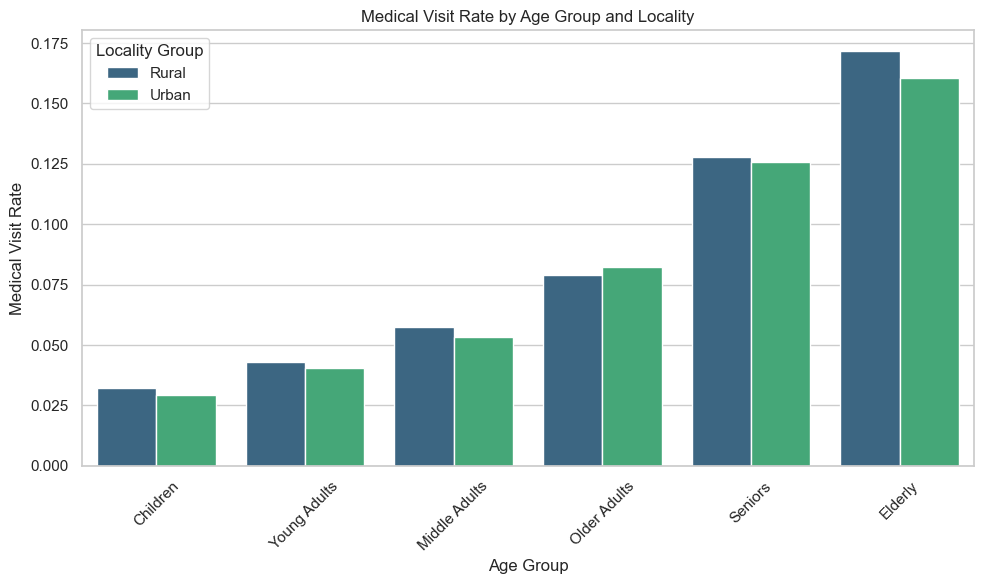

In [66]:

# Set the plot style
sns.set_theme(style="whitegrid")

# Create a grouped bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=pers_agg_rural_age, x="Age_Group", y="medical_visit_rate", hue="Locality_Group", palette="viridis")

# Customize plot
plt.title("Medical Visit Rate by Age Group and Locality")
plt.xlabel("Age Group")
plt.ylabel("Medical Visit Rate")
plt.legend(title="Locality Group")
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


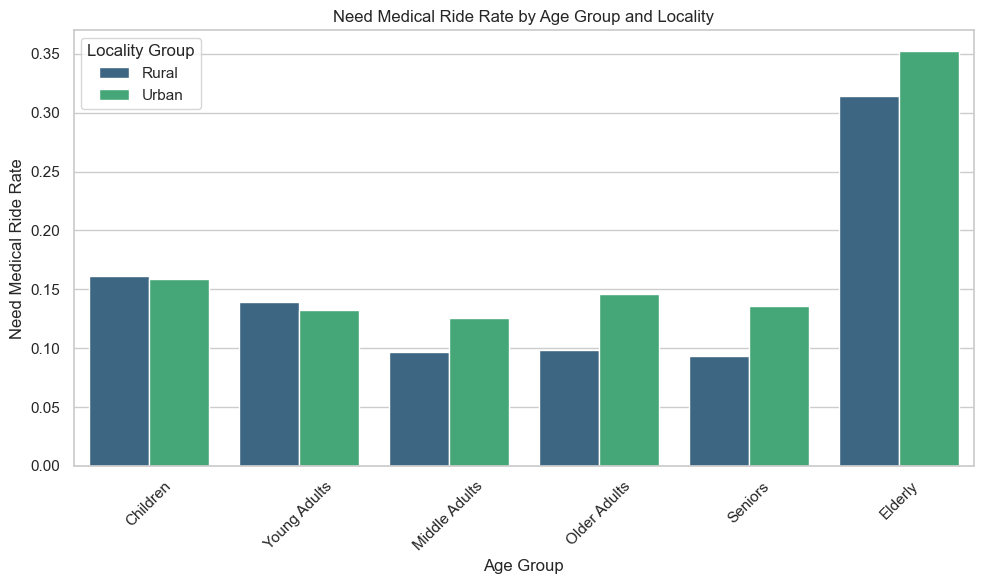

In [67]:
# Set the plot style
sns.set_theme(style="whitegrid")

# Create a grouped bar plot for Need_Medical_ride_rate
plt.figure(figsize=(10, 6))
sns.barplot(data=pers_agg_rural_age, x="Age_Group", y="Need_Medical_ride_rate", hue="Locality_Group", palette="viridis")

# Customize plot
plt.title("Need Medical Ride Rate by Age Group and Locality")
plt.xlabel("Age Group")
plt.ylabel("Need Medical Ride Rate")
plt.legend(title="Locality Group")
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


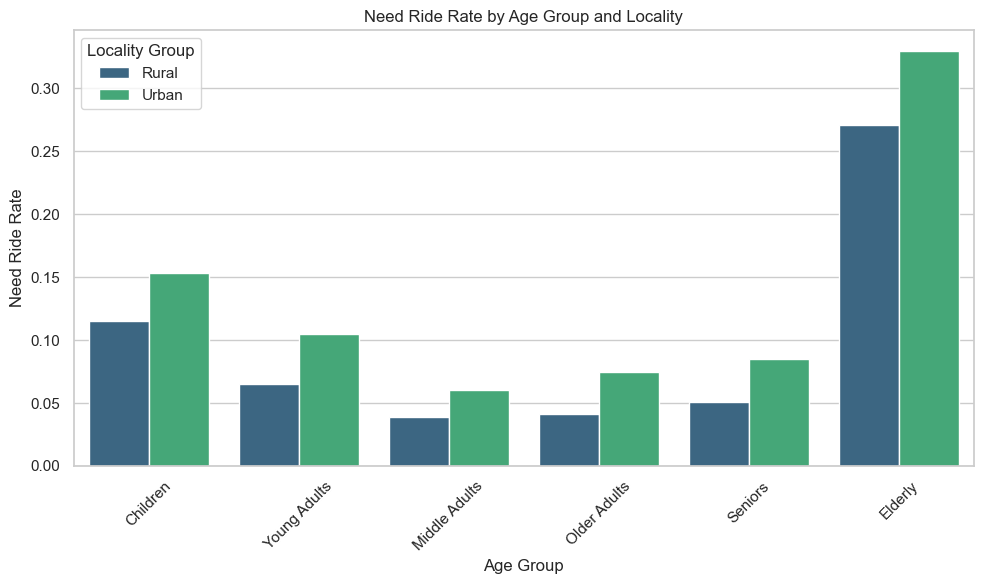

In [68]:
# Set the plot style
sns.set_theme(style="whitegrid")

# Create a grouped bar plot for Need_ride_rate
plt.figure(figsize=(10, 6))
sns.barplot(data=pers_agg_rural_age, x="Age_Group", y="Need_ride_rate", hue="Locality_Group", palette="viridis")

# Customize plot
plt.title("Need Ride Rate by Age Group and Locality")
plt.xlabel("Age Group")
plt.ylabel("Need Ride Rate")
plt.legend(title="Locality Group")
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


### Aggregate data by Urban-Rural and Gender 

In [69]:
# Aggregate data by Age and Gender
pers_agg_rural_gender = pers_filter.groupby(['Locality_Group', 'Gender_Group']).agg(
    Total_Medical_Visits=('Medical_Visits', 'sum'),  # Sum of medical trips
    Min_Medical_Visits=('Medical_Visits', 'min'),  # Minimum medical trips
    Max_Medical_Visits=('Medical_Visits', 'max'),  # Maximum medical trips
    Avg_Medical_Visits=('Medical_Visits', 'mean'),  # Average medical trips
    Average_Age=('R_AGE', 'mean'),           # Average age
    Total_Need_ride=('Need_ride', 'sum'),  # Sum of persons who need ride
    Need_med_ride_Total=('Need_med_ride', 'sum'),  # Sum of persons who need medical ride
    Person_Count=('PERSONID', 'count')            # Number of persons
).reset_index()

In [70]:
pers_agg_rural_gender

,Locality_Group,Gender_Group,Total_Medical_Visits,Min_Medical_Visits,Max_Medical_Visits,Avg_Medical_Visits,Average_Age,Total_Need_ride,Need_med_ride_Total,Person_Count
0,Rural,Female,2316,0,4,0.093361,50.593179,1848,302,24807
1,Rural,Male,1723,0,4,0.072044,50.765638,1339,189,23916
2,Urban,Female,7651,0,8,0.085746,47.378341,9957,1299,89229
3,Urban,Male,5088,0,5,0.062771,46.699360,7204,721,81057


In [71]:
# Create a medical visit rate column
pers_agg_rural_gender['medical_visit_rate'] = pers_agg_rural_gender['Total_Medical_Visits']/pers_agg_rural_gender['Person_Count']
# Create a Need ride rate column
pers_agg_rural_gender['Need_ride_rate'] = pers_agg_rural_gender['Total_Need_ride']/pers_agg_rural_gender['Person_Count']
# Create a Need medical ride rate column
pers_agg_rural_gender['Need_Medical_ride_rate'] = pers_agg_rural_gender['Need_med_ride_Total']/pers_agg_rural_gender['Total_Medical_Visits']

In [72]:
pers_agg_rural_gender

,Locality_Group,Gender_Group,Total_Medical_Visits,Min_Medical_Visits,Max_Medical_Visits,Avg_Medical_Visits,Average_Age,Total_Need_ride,Need_med_ride_Total,Person_Count,medical_visit_rate,Need_ride_rate,Need_Medical_ride_rate
0,Rural,Female,2316,0,4,0.093361,50.593179,1848,302,24807,0.093361,0.074495,0.130397
1,Rural,Male,1723,0,4,0.072044,50.765638,1339,189,23916,0.072044,0.055988,0.109692
2,Urban,Female,7651,0,8,0.085746,47.378341,9957,1299,89229,0.085746,0.111589,0.169782
3,Urban,Male,5088,0,5,0.062771,46.699360,7204,721,81057,0.062771,0.088876,0.141706


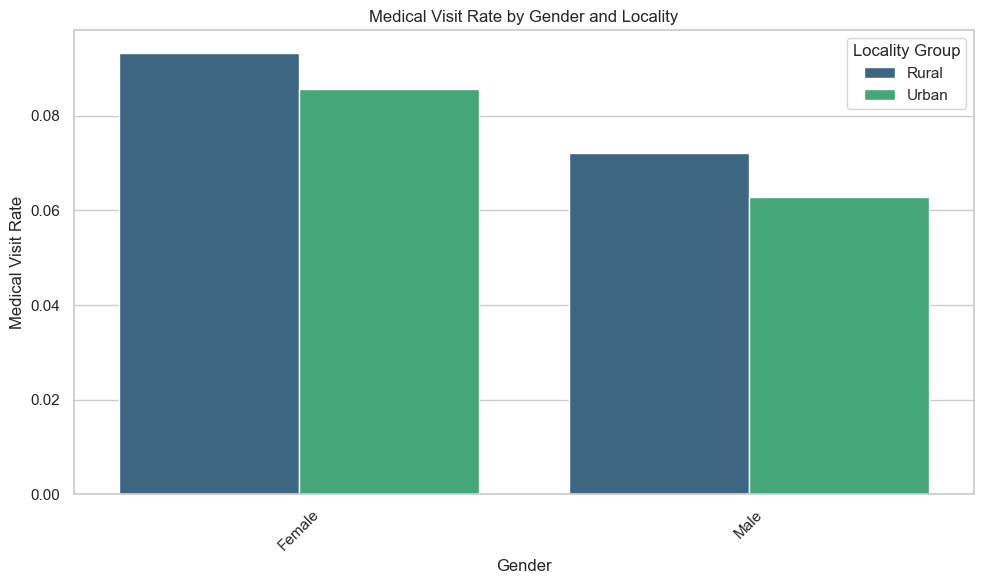

In [73]:
# Set the plot style
sns.set_theme(style="whitegrid")

# Create a grouped bar plot for Need_ride_rate
plt.figure(figsize=(10, 6))
sns.barplot(data=pers_agg_rural_gender, x="Gender_Group", y="medical_visit_rate", hue="Locality_Group", palette="viridis")

# Customize plot
plt.title("Medical Visit Rate by Gender and Locality")
plt.xlabel("Gender")
plt.ylabel("Medical Visit Rate")
plt.legend(title="Locality Group")
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

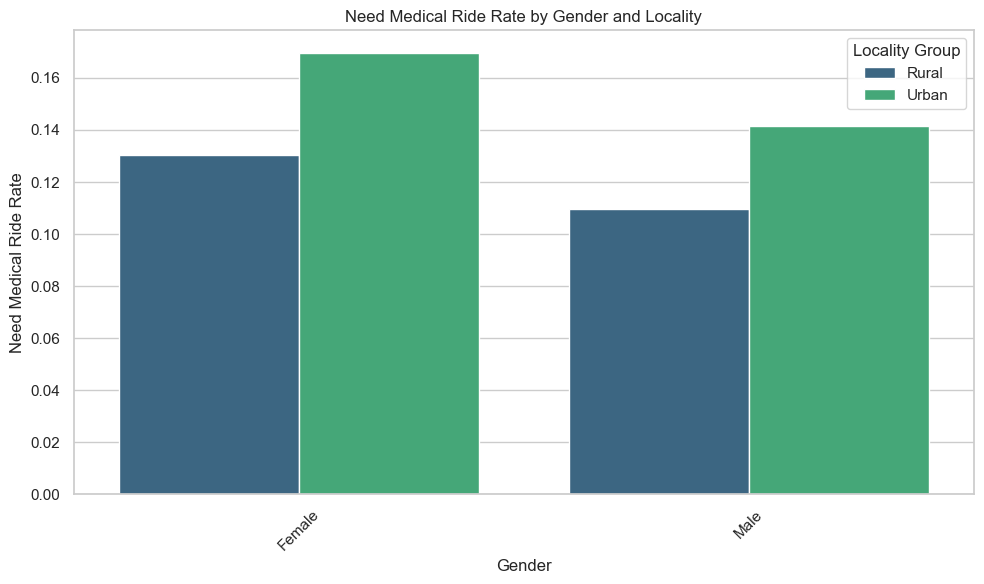

In [74]:
# Set the plot style
sns.set_theme(style="whitegrid")

# Create a grouped bar plot for Need_ride_rate
plt.figure(figsize=(10, 6))
sns.barplot(data=pers_agg_rural_gender, x="Gender_Group", y="Need_Medical_ride_rate", hue="Locality_Group", palette="viridis")

# Customize plot
plt.title("Need Medical Ride Rate by Gender and Locality")
plt.xlabel("Gender")
plt.ylabel("Need Medical Ride Rate")
plt.legend(title="Locality Group")
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

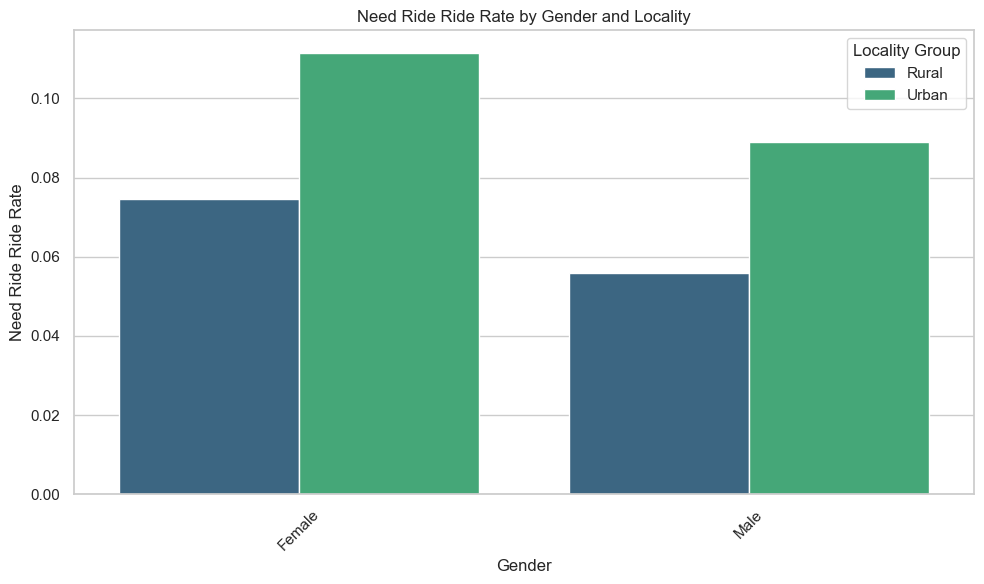

In [75]:
# Set the plot style
sns.set_theme(style="whitegrid")

# Create a grouped bar plot for Need_ride_rate
plt.figure(figsize=(10, 6))
sns.barplot(data=pers_agg_rural_gender, x="Gender_Group", y="Need_ride_rate", hue="Locality_Group", palette="viridis")

# Customize plot
plt.title("Need Ride Ride Rate by Gender and Locality")
plt.xlabel("Gender")
plt.ylabel("Need Ride Ride Rate")
plt.legend(title="Locality Group")
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

### Aggregate data by Age_Group only

In [76]:
# Aggregate data by Age
pers_agg_age = pers_filter.groupby(['Age_Group']).agg(
    Total_Medical_Visits=('Medical_Visits', 'sum'),  # Sum of medical trips
    Min_Medical_Visits=('Medical_Visits', 'min'),  # Minimum medical trips
    Max_Medical_Visits=('Medical_Visits', 'max'),  # Maximum medical trips
    Avg_Medical_Visits=('Medical_Visits', 'mean'),  # Average medical trips
    Average_Age=('R_AGE', 'mean'),           # Average age
    Total_Need_ride=('Need_ride', 'sum'),  # Sum of persons who need ride
    Need_med_ride_Total=('Need_med_ride', 'sum'),  # Sum of persons who need medical ride
    Person_Count=('PERSONID', 'count')            # Number of persons
).reset_index()

In [77]:
pers_agg_age

,Age_Group,Total_Medical_Visits,Min_Medical_Visits,Max_Medical_Visits,Avg_Medical_Visits,Average_Age,Total_Need_ride,Need_med_ride_Total,Person_Count
0,Children,827,0,4,0.029913,11.092560,4028,132,27647
1,Young Adults,1431,0,5,0.040941,27.110320,3434,191,34953
2,Middle Adults,2142,0,5,0.054194,42.097457,2226,257,39525
3,Older Adults,4931,0,8,0.081430,57.456230,4016,664,60555
4,Seniors,5872,0,4,0.126429,70.584412,3526,728,46445
5,Elderly,1561,0,5,0.163012,84.427005,3031,536,9576


### Calculate the rates

In [78]:
# Create a medical visit rate column
pers_agg_age['medical_visit_rate'] = pers_agg_age['Total_Medical_Visits']/pers_agg_age['Person_Count']
# Create a Need ride rate column
pers_agg_age['Need_ride_rate'] = pers_agg_age['Total_Need_ride']/pers_agg_age['Person_Count']
# Create a Need medical ride rate column
pers_agg_age['Need_Medical_ride_rate'] = pers_agg_age['Need_med_ride_Total']/pers_agg_age['Total_Medical_Visits']

In [79]:
pers_agg_age

,Age_Group,Total_Medical_Visits,Min_Medical_Visits,Max_Medical_Visits,Avg_Medical_Visits,Average_Age,Total_Need_ride,Need_med_ride_Total,Person_Count,medical_visit_rate,Need_ride_rate,Need_Medical_ride_rate
0,Children,827,0,4,0.029913,11.092560,4028,132,27647,0.029913,0.145694,0.159613
1,Young Adults,1431,0,5,0.040941,27.110320,3434,191,34953,0.040941,0.098246,0.133473
2,Middle Adults,2142,0,5,0.054194,42.097457,2226,257,39525,0.054194,0.056319,0.119981
3,Older Adults,4931,0,8,0.081430,57.456230,4016,664,60555,0.081430,0.066320,0.134658
4,Seniors,5872,0,4,0.126429,70.584412,3526,728,46445,0.126429,0.075918,0.123978
5,Elderly,1561,0,5,0.163012,84.427005,3031,536,9576,0.163012,0.316520,0.343370


### visualize

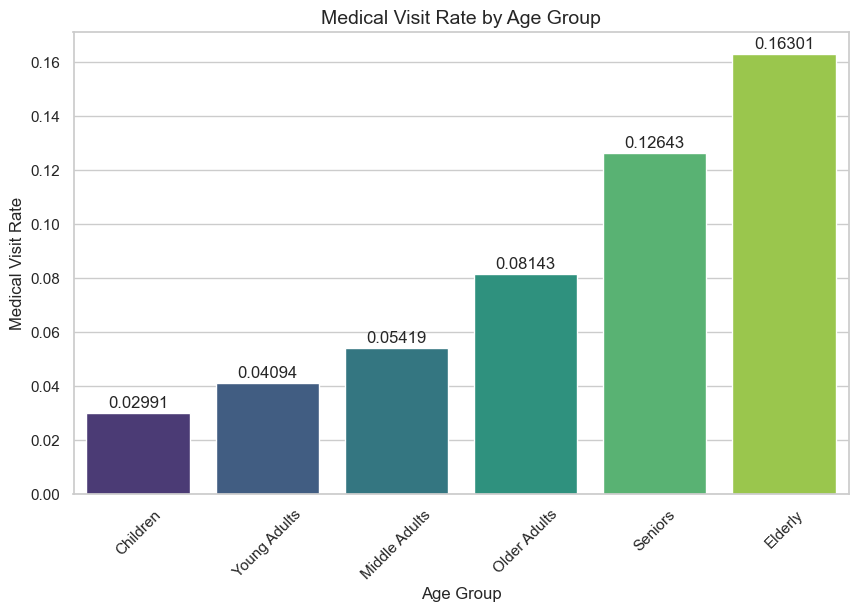

In [80]:
# Setting the visual style
sns.set_theme(style="whitegrid")

# Creating the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Age_Group", y="medical_visit_rate", data=pers_agg_age, palette="viridis")

# Adding labels and title
plt.xlabel("Age Group", fontsize=12)
plt.ylabel("Medical Visit Rate", fontsize=12)
plt.title("Medical Visit Rate by Age Group", fontsize=14)
plt.xticks(rotation=45)

# Displaying the values on top of bars
for index, value in enumerate(pers_agg_age["medical_visit_rate"]):
    plt.text(index, value + 0.002, f'{value:.5f}', ha='center', fontsize=12)

# Show the plot
plt.show()


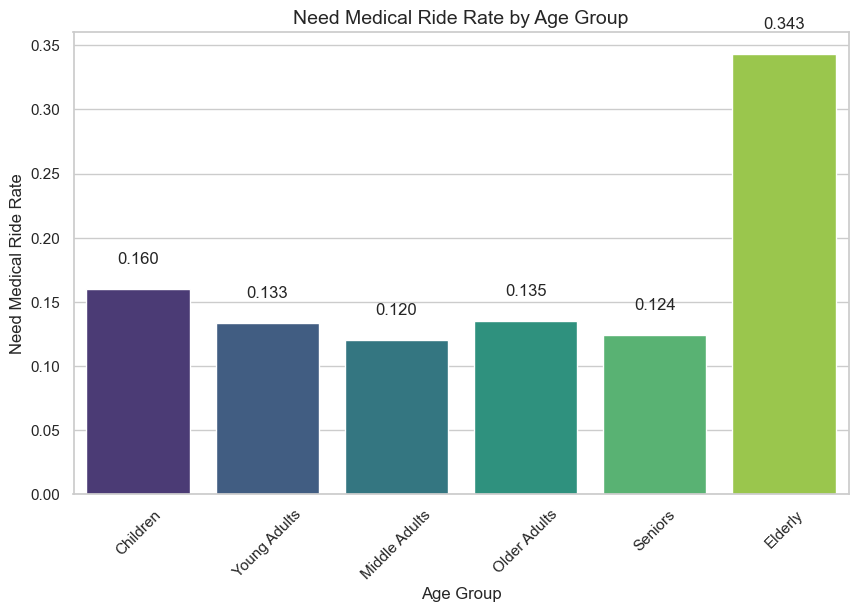

In [81]:
# Setting the visual style
sns.set_theme(style="whitegrid")

# Creating the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Age_Group", y="Need_Medical_ride_rate", data=pers_agg_age, palette="viridis")

# Adding labels and title
plt.xlabel("Age Group", fontsize=12)
plt.ylabel("Need Medical Ride Rate", fontsize=12)
plt.title("Need Medical Ride Rate by Age Group", fontsize=14)
plt.xticks(rotation=45)

# Displaying the values on top of bars
for index, value in enumerate(pers_agg_age["Need_Medical_ride_rate"]):
    plt.text(index, value + 0.02, f'{value:.3f}', ha='center', fontsize=12)

# Show the plot
plt.show()

### Aggregate data by Gender_Group only

In [82]:
# Aggregate data by Gender_Group
pers_agg_gender = pers_filter.groupby(['Gender_Group']).agg(
    Total_Medical_Visits=('Medical_Visits', 'sum'),  # Sum of medical trips
    Min_Medical_Visits=('Medical_Visits', 'min'),  # Minimum medical trips
    Max_Medical_Visits=('Medical_Visits', 'max'),  # Maximum medical trips
    Avg_Medical_Visits=('Medical_Visits', 'mean'),  # Average medical trips
    Average_Age=('R_AGE', 'mean'),           # Average age
    Total_Need_ride=('Need_ride', 'sum'),  # Sum of persons who need ride
    Need_med_ride_Total=('Need_med_ride', 'sum'),  # Sum of persons who need medical ride
    Person_Count=('PERSONID', 'count')            # Number of persons
).reset_index()

In [83]:
pers_agg_gender

,Gender_Group,Total_Medical_Visits,Min_Medical_Visits,Max_Medical_Visits,Avg_Medical_Visits,Average_Age,Total_Need_ride,Need_med_ride_Total,Person_Count
0,Female,9967,0,8,0.087402,48.077686,11805,1601,114036
1,Male,6811,0,5,0.064883,47.625780,8543,910,104973


### Calculate the rates

In [84]:
# Create a medical visit rate column
pers_agg_gender['medical_visit_rate'] = pers_agg_gender['Total_Medical_Visits']/pers_agg_gender['Person_Count']
# Create a Need ride rate column
pers_agg_gender['Need_ride_rate'] = pers_agg_gender['Total_Need_ride']/pers_agg_gender['Person_Count']
# Create a Need medical ride rate column
pers_agg_gender['Need_Medical_ride_rate'] = pers_agg_gender['Need_med_ride_Total']/pers_agg_gender['Total_Medical_Visits']

In [85]:
pers_agg_gender

,Gender_Group,Total_Medical_Visits,Min_Medical_Visits,Max_Medical_Visits,Avg_Medical_Visits,Average_Age,Total_Need_ride,Need_med_ride_Total,Person_Count,medical_visit_rate,Need_ride_rate,Need_Medical_ride_rate
0,Female,9967,0,8,0.087402,48.077686,11805,1601,114036,0.087402,0.103520,0.160630
1,Male,6811,0,5,0.064883,47.625780,8543,910,104973,0.064883,0.081383,0.133607


### visualize

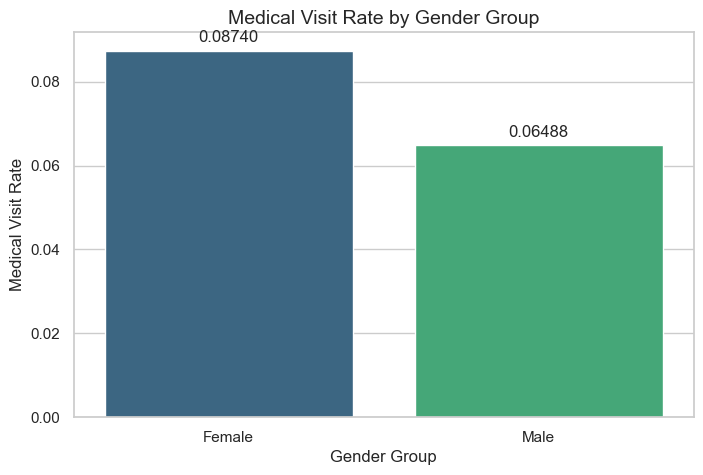

In [86]:
# Setting the visual style
sns.set_theme(style="whitegrid")

# Creating the bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x="Gender_Group", y="medical_visit_rate", data=pers_agg_gender, palette="viridis")

# Adding labels and title
plt.xlabel("Gender Group", fontsize=12)
plt.ylabel("Medical Visit Rate", fontsize=12)
plt.title("Medical Visit Rate by Gender Group", fontsize=14)

# Displaying the values on top of bars
for index, value in enumerate(pers_agg_gender["medical_visit_rate"]):
    plt.text(index, value + 0.002, f'{value:.5f}', ha='center', fontsize=12)

# Show the plot
plt.show()


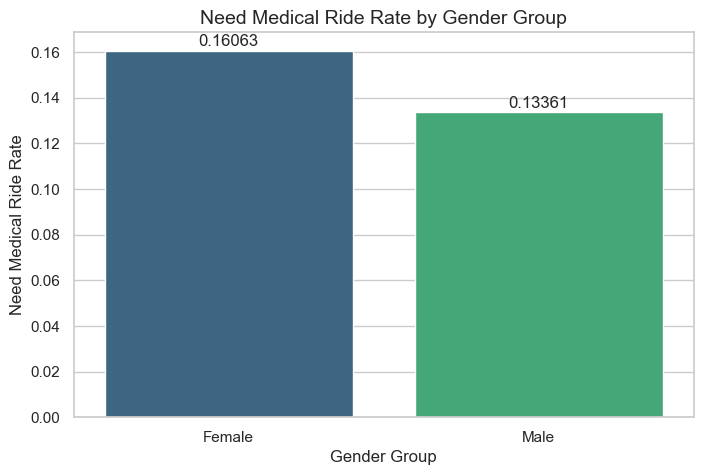

In [87]:
# Setting the visual style
sns.set_theme(style="whitegrid")

# Creating the bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x="Gender_Group", y="Need_Medical_ride_rate", data=pers_agg_gender, palette="viridis")

# Adding labels and title
plt.xlabel("Gender Group", fontsize=12)
plt.ylabel("Need Medical Ride Rate", fontsize=12)
plt.title("Need Medical Ride Rate by Gender Group", fontsize=14)

# Displaying the values on top of bars
for index, value in enumerate(pers_agg_gender["Need_Medical_ride_rate"]):
    plt.text(index, value + 0.002, f'{value:.5f}', ha='center', fontsize=12)

# Show the plot
plt.show()

### Aggregate data by Age and Gender only

In [88]:
# Aggregate data by Age and Gender
pers_aggregate = pers_filter.groupby(['Age_Group', 'Gender_Group']).agg(
    Total_Medical_Visits=('Medical_Visits', 'sum'),  # Sum of medical trips
    Min_Medical_Visits=('Medical_Visits', 'min'),  # Minimum medical trips
    Max_Medical_Visits=('Medical_Visits', 'max'),  # Maximum medical trips
    Avg_Medical_Visits=('Medical_Visits', 'mean'),  # Average medical trips
    Average_Age=('R_AGE', 'mean'),           # Average age
    Total_Need_ride=('Need_ride', 'sum'),  # Sum of persons who need ride
    Need_med_ride_Total=('Need_med_ride', 'sum'),  # Sum of persons who need medical ride
    Person_Count=('PERSONID', 'count')            # Number of persons
).reset_index()

In [89]:
pers_aggregate

,Age_Group,Gender_Group,Total_Medical_Visits,Min_Medical_Visits,Max_Medical_Visits,Avg_Medical_Visits,Average_Age,Total_Need_ride,Need_med_ride_Total,Person_Count
0,Children,Female,438,0,4,0.032289,11.103428,1939,74,13565
1,Children,Male,389,0,3,0.027624,11.082091,2089,58,14082
2,Young Adults,Female,965,0,5,0.052460,27.176570,1803,121,18395
3,Young Adults,Male,466,0,4,0.028143,27.036719,1631,70,16558
4,Middle Adults,Female,1433,0,5,0.069328,42.113498,1252,158,20670
5,Middle Adults,Male,709,0,5,0.037603,42.079873,974,99,18855
6,Older Adults,Female,3149,0,8,0.097080,57.456670,2443,423,32437
7,Older Adults,Male,1782,0,4,0.063376,57.455722,1573,241,28118
8,Seniors,Female,3185,0,4,0.133588,70.531415,2313,467,23842
9,Seniors,Male,2687,0,4,0.118878,70.640313,1213,261,22603


### Calculate the rates

In [90]:
# Create a medical visit rate column
pers_aggregate['medical_visit_rate'] = pers_aggregate['Total_Medical_Visits']/pers_aggregate['Person_Count']
# Create a Need ride rate column
pers_aggregate['Need_ride_rate'] = pers_aggregate['Total_Need_ride']/pers_aggregate['Person_Count']
# Create a Need medical ride rate column
pers_aggregate['Need_Medical_ride_rate'] = pers_aggregate['Need_med_ride_Total']/pers_aggregate['Total_Medical_Visits']

# pers_aggregate

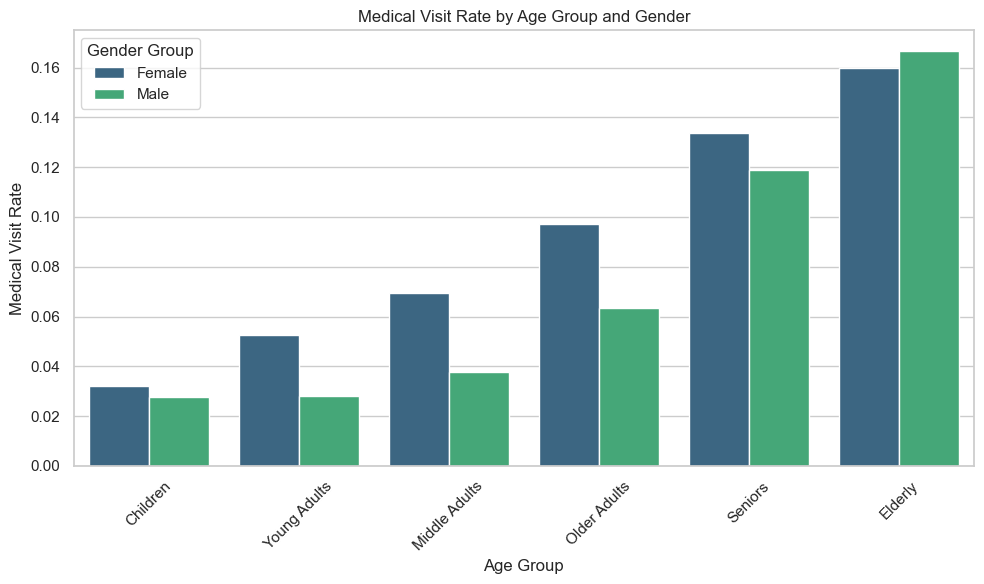

In [91]:
# Set the plot style
sns.set_theme(style="whitegrid")

# Create a grouped bar plot for Need_Medical_ride_rate
plt.figure(figsize=(10, 6))
sns.barplot(data=pers_aggregate, x="Age_Group", y="medical_visit_rate", hue="Gender_Group", palette="viridis")

# Customize plot
plt.title("Medical Visit Rate by Age Group and Gender")
plt.xlabel("Age Group")
plt.ylabel("Medical Visit Rate")
plt.legend(title="Gender Group")
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

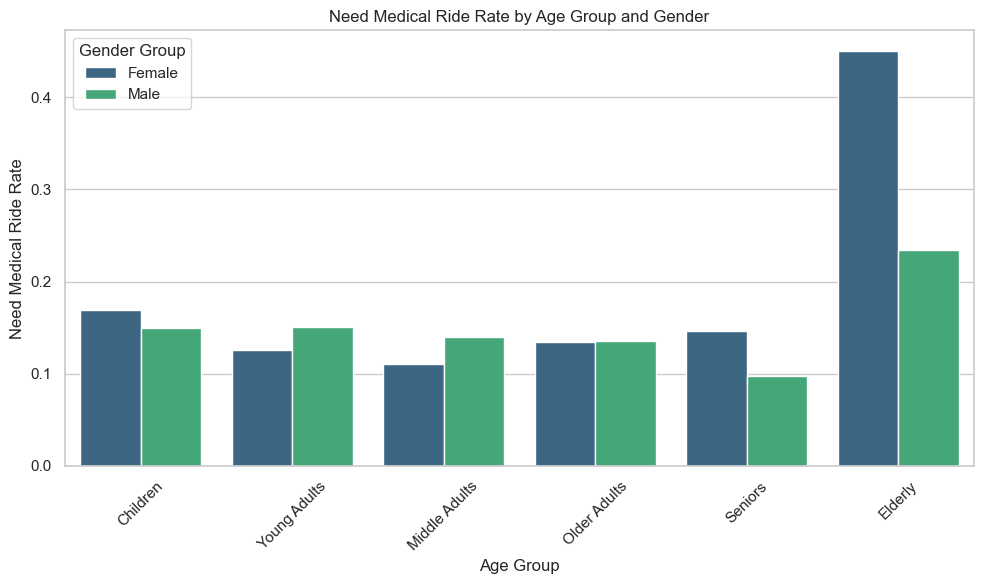

In [92]:
# Set the plot style
sns.set_theme(style="whitegrid")

# Create a grouped bar plot for Need_Medical_ride_rate
plt.figure(figsize=(10, 6))
sns.barplot(data=pers_aggregate, x="Age_Group", y="Need_Medical_ride_rate", hue="Gender_Group", palette="viridis")

# Customize plot
plt.title("Need Medical Ride Rate by Age Group and Gender")
plt.xlabel("Age Group")
plt.ylabel("Need Medical Ride Rate")
plt.legend(title="Gender Group")
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


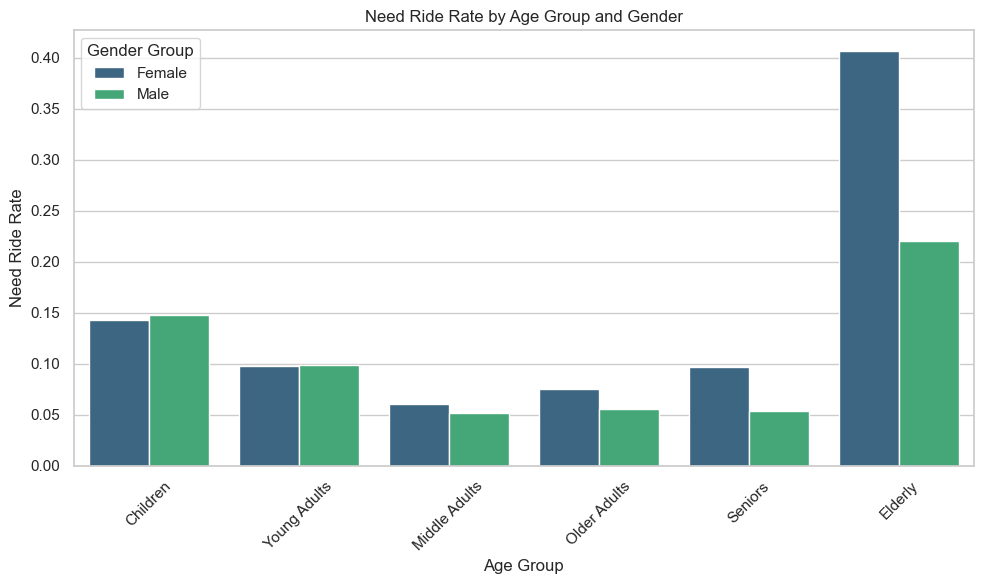

In [93]:
# Set the plot style
sns.set_theme(style="whitegrid")

# Create a grouped bar plot for Need_Medical_ride_rate
plt.figure(figsize=(10, 6))
sns.barplot(data=pers_aggregate, x="Age_Group", y="Need_ride_rate", hue="Gender_Group", palette="viridis")

# Customize plot
plt.title("Need Ride Rate by Age Group and Gender")
plt.xlabel("Age Group")
plt.ylabel("Need Ride Rate")
plt.legend(title="Gender Group")
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


# KY AGE and SEX by Census Tract Using API  code

In [94]:
# Define Constants
STATE_FIPS = "21"  # Kentucky
YEAR = 2019
DATASET = "acs5"

# Variables: Population breakdown by age & gender
VARIABLES = {
    "B01001_001E": "Total Population",
    "B01001_002E": "Male Population",
    "B01001_026E": "Female Population",
    "B01001_003E": "Male Under 5",
    "B01001_004E": "Male 5-9",
    "B01001_005E": "Male 10-14",
    "B01001_006E": "Male 15-17",
    "B01001_007E": "Male 18-19",
    "B01001_008E": "Male 20",
    "B01001_009E": "Male 21",
    "B01001_010E": "Male 22-24",
    "B01001_011E": "Male 25-29",
    "B01001_012E": "Male 30-34",
    "B01001_013E": "Male 35-39",
    "B01001_014E": "Male 40-44",
    "B01001_015E": "Male 45-49",
    "B01001_016E": "Male 50-54",
    "B01001_017E": "Male 55-59",
    "B01001_018E": "Male 60-61",
    "B01001_019E": "Male 62-64",
    "B01001_020E": "Male 65-66",
    "B01001_021E": "Male 67-69",
    "B01001_022E": "Male 70-74",
    "B01001_023E": "Male 75-79",
    "B01001_024E": "Male 80-84",
    "B01001_025E": "Male 85+",
    "B01001_027E": "Female Under 5",
    "B01001_028E": "Female 5-9",
    "B01001_029E": "Female 10-14",
    "B01001_030E": "Female 15-17",
    "B01001_031E": "Female 18-19",
    "B01001_032E": "Female 20",
    "B01001_033E": "Female 21",
    "B01001_034E": "Female 22-24",
    "B01001_035E": "Female 25-29",
    "B01001_036E": "Female 30-34",
    "B01001_037E": "Female 35-39",
    "B01001_038E": "Female 40-44",
    "B01001_039E": "Female 45-49",
    "B01001_040E": "Female 50-54",
    "B01001_041E": "Female 55-59",
    "B01001_042E": "Female 60-61",
    "B01001_043E": "Female 62-64",
    "B01001_044E": "Female 65-66",
    "B01001_045E": "Female 67-69",
    "B01001_046E": "Female 70-74",
    "B01001_047E": "Female 75-79",
    "B01001_048E": "Female 80-84",
    "B01001_049E": "Female 85+",
    "NAME": "NAME"
}

# Fetch data by Census Tract
data = c.acs5.state_county_tract(
    list(VARIABLES.keys()),  # Census variables
    STATE_FIPS,
    "*",  # All counties
    "*",  # All census tracts
    year=YEAR,
)

# Convert to DataFrame
df = pd.DataFrame(data)

# Rename the columns to readable names
df.rename(columns=VARIABLES, inplace=True)

# Extract County Name from 'NAME' column
df["County Name"] = df["NAME"].str.extract(r"([^,]+) County")  # Extract county name

# Create 'tract_number' by concatenating FIPS codes
df["tract_number"] = df["state"].astype(str) + df["county"].astype(str).str.zfill(3) + df["tract"].astype(str).str.zfill(6)

# Create 'tract_name' (e.g., "Fayette County, Tract 950201")
df["tract_name"] = df["County Name"] + " County, Tract " + df["tract"].astype(str)

# Drop unnecessary columns
df.drop(columns=["state", "county", "tract", "NAME"], inplace=True)

In [95]:
df

,Total Population,Male Population,Female Population,Male Under 5,Male 5-9,Male 10-14,Male 15-17,Male 18-19,Male 20,Male 21,...,Female 65-66,Female 67-69,Female 70-74,Female 75-79,Female 80-84,Female 85+,GEO_ID,County Name,tract_number,tract_name
0,1607.0,748.0,859.0,50.0,49.0,26.0,17.0,19.0,0.0,0.0,...,7.0,21.0,50.0,53.0,18.0,14.0,1400000US21001970100,Adair,21001970100,"Adair County, Tract 970100"
1,2003.0,998.0,1005.0,51.0,34.0,55.0,45.0,14.0,0.0,14.0,...,14.0,62.0,35.0,19.0,17.0,6.0,1400000US21001970200,Adair,21001970200,"Adair County, Tract 970200"
2,3258.0,1784.0,1474.0,85.0,129.0,109.0,90.0,15.0,22.0,63.0,...,53.0,23.0,91.0,32.0,132.0,9.0,1400000US21001970300,Adair,21001970300,"Adair County, Tract 970300"
3,4405.0,1953.0,2452.0,220.0,26.0,144.0,72.0,20.0,42.0,2.0,...,33.0,88.0,150.0,71.0,181.0,68.0,1400000US21001970401,Adair,21001970401,"Adair County, Tract 970401"
4,4301.0,2232.0,2069.0,82.0,199.0,89.0,95.0,343.0,82.0,72.0,...,49.0,98.0,61.0,44.0,34.0,22.0,1400000US21001970402,Adair,21001970402,"Adair County, Tract 970402"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,3331.0,1647.0,1684.0,94.0,82.0,39.0,74.0,59.0,6.0,48.0,...,46.0,121.0,108.0,113.0,41.0,67.0,1400000US21239050106,Woodford,21239050106,"Woodford County, Tract 050106"
1111,4299.0,2179.0,2120.0,210.0,204.0,91.0,73.0,19.0,24.0,13.0,...,22.0,74.0,90.0,39.0,65.0,60.0,1400000US21239050107,Woodford,21239050107,"Woodford County, Tract 050107"
1112,3662.0,1724.0,1938.0,55.0,56.0,139.0,71.0,29.0,14.0,37.0,...,134.0,70.0,174.0,58.0,50.0,26.0,1400000US21239050200,Woodford,21239050200,"Woodford County, Tract 050200"
1113,1888.0,1000.0,888.0,32.0,33.0,69.0,29.0,0.0,40.0,0.0,...,35.0,35.0,17.0,46.0,7.0,6.0,1400000US21239050300,Woodford,21239050300,"Woodford County, Tract 050300"


### Reshape rows and columns of the Dataset

In [96]:
# Define age groups for restructuring
columns_to_melt = [
    "Under 5", "5-9", "10-14", "15-17", "18-19", "20", "21", "22-24", "25-29", 
    "30-34", "35-39", "40-44", "45-49", "50-54", "55-59", "60-61", "62-64", 
    "65-66", "67-69", "70-74", "75-79", "80-84", "85+"
]

# Define the column names for male, female, and total populations
value_vars_male = [f'Male {age}' for age in columns_to_melt]  # Male population by age group
value_vars_female = [f'Female {age}' for age in columns_to_melt]  # Female population by age group

# Ensure 'tract_number' and 'tract_name' exist as identifiers
id_vars = ['tract_number', 'tract_name']

# Melt data for Male and Female population by age groups
melted_male = df.melt(
    id_vars=id_vars, value_vars=value_vars_male,
    var_name="AGE", value_name="Estimate Male Population"
)

melted_female = df.melt(
    id_vars=id_vars, value_vars=value_vars_female,
    var_name="AGE", value_name="Estimate Female Population"
)

# Clean up the AGE column to extract age groups (remove prefix)
melted_male["AGE"] = melted_male["AGE"].str.extract(r"Male\s*(.*)$")  # Extract age group for Male
melted_female["AGE"] = melted_female["AGE"].str.extract(r"Female\s*(.*)$")  # Extract age group for Female

# Merge the male and female datasets
restr_KYage = melted_male.merge(
    melted_female, on=["tract_number", "tract_name", "AGE"], how="left"
)

# Calculate Total Population as the sum of Male and Female populations for each age group
restr_KYage["Estimate Total Population"] = restr_KYage["Estimate Male Population"] + restr_KYage["Estimate Female Population"]


In [97]:
restr_KYage

,tract_number,tract_name,AGE,Estimate Male Population,Estimate Female Population,Estimate Total Population
0,21001970100,"Adair County, Tract 970100",Under 5,50.0,33.0,83.0
1,21001970200,"Adair County, Tract 970200",Under 5,51.0,45.0,96.0
2,21001970300,"Adair County, Tract 970300",Under 5,85.0,63.0,148.0
3,21001970401,"Adair County, Tract 970401",Under 5,220.0,173.0,393.0
4,21001970402,"Adair County, Tract 970402",Under 5,82.0,30.0,112.0
...,...,...,...,...,...,...
25640,21239050106,"Woodford County, Tract 050106",85+,31.0,67.0,98.0
25641,21239050107,"Woodford County, Tract 050107",85+,34.0,60.0,94.0
25642,21239050200,"Woodford County, Tract 050200",85+,33.0,26.0,59.0
25643,21239050300,"Woodford County, Tract 050300",85+,7.0,6.0,13.0


### Check if reshaping of dataset maintain same values in the columns

In [98]:
# Group by 'Geographic Area Name' and 'Geography', summing up numeric columns
aggregated_df = restr_KYage.groupby(['tract_number', 'tract_name'], as_index=False).sum()

In [99]:
aggregated_df

,tract_number,tract_name,AGE,Estimate Male Population,Estimate Female Population,Estimate Total Population
0,21001970100,"Adair County, Tract 970100",Under 55-910-1415-1718-19202122-2425-2930-3435...,748.0,859.0,1607.0
1,21001970200,"Adair County, Tract 970200",Under 55-910-1415-1718-19202122-2425-2930-3435...,998.0,1005.0,2003.0
2,21001970300,"Adair County, Tract 970300",Under 55-910-1415-1718-19202122-2425-2930-3435...,1784.0,1474.0,3258.0
3,21001970401,"Adair County, Tract 970401",Under 55-910-1415-1718-19202122-2425-2930-3435...,1953.0,2452.0,4405.0
4,21001970402,"Adair County, Tract 970402",Under 55-910-1415-1718-19202122-2425-2930-3435...,2232.0,2069.0,4301.0
...,...,...,...,...,...,...
1110,21239050106,"Woodford County, Tract 050106",Under 55-910-1415-1718-19202122-2425-2930-3435...,1647.0,1684.0,3331.0
1111,21239050107,"Woodford County, Tract 050107",Under 55-910-1415-1718-19202122-2425-2930-3435...,2179.0,2120.0,4299.0
1112,21239050200,"Woodford County, Tract 050200",Under 55-910-1415-1718-19202122-2425-2930-3435...,1724.0,1938.0,3662.0
1113,21239050300,"Woodford County, Tract 050300",Under 55-910-1415-1718-19202122-2425-2930-3435...,1000.0,888.0,1888.0


### Restructure the Age Range to align with the NHTS dataset

In [100]:
# Define the new age ranges and corresponding labels 
new_age_ranges = {
    "5-18": ["5-9", "10-14", "15-17"],
    "18-35": ["18-19", "20", "21", "22-24", "25-29", "30-34"],
    "35-50": ["35-39", "40-44", "45-49"],
    "50-65": ["50-54", "55-59", "60-61", "62-64"],
    "65-80": ["65-66", "67-69", "70-74", "75-79"],
    "80-92": ["80-84", "85+"]
}

age_labels = ["Children", "Young Adults", "Middle Adults", "Older Adults", "Seniors", "Elderly"]

# Initialize an empty list for the restructured data
restructured_data = []

# Group and sum the populations for each new age range by tract_number and tract_name
for (new_range, old_ranges), label in zip(new_age_ranges.items(), age_labels):
    for (tract_num, tract_nme) in restr_KYage[["tract_number", "tract_name"]].drop_duplicates().itertuples(index=False):
        filtered_data = restr_KYage[
            (restr_KYage["tract_number"] == tract_num) & 
            (restr_KYage["tract_name"] == tract_nme) & 
            (restr_KYage["AGE"].str.strip().isin(old_ranges))
        ]
        
        total_pop = filtered_data["Estimate Total Population"].sum()
        male_pop = filtered_data["Estimate Male Population"].sum()
        female_pop = filtered_data["Estimate Female Population"].sum()
        
        restructured_data.append({
            "tract_number": tract_num,
            "tract_name": tract_nme,
            "New_Age_Range": new_range,
            "Age_Group": label,
            "Total_Estimate": total_pop,
            "Male_Estimate": male_pop,
            "Female_Estimate": female_pop
        })

# Convert the restructured data to a DataFrame
KYage_trct = pd.DataFrame(restructured_data)

In [101]:
KYage_trct

,tract_number,tract_name,New_Age_Range,Age_Group,Total_Estimate,Male_Estimate,Female_Estimate
0,21001970100,"Adair County, Tract 970100",5-18,Children,155.0,92.0,63.0
1,21001970200,"Adair County, Tract 970200",5-18,Children,309.0,134.0,175.0
2,21001970300,"Adair County, Tract 970300",5-18,Children,482.0,328.0,154.0
3,21001970401,"Adair County, Tract 970401",5-18,Children,709.0,242.0,467.0
4,21001970402,"Adair County, Tract 970402",5-18,Children,619.0,383.0,236.0
...,...,...,...,...,...,...,...
6685,21239050106,"Woodford County, Tract 050106",80-92,Elderly,200.0,92.0,108.0
6686,21239050107,"Woodford County, Tract 050107",80-92,Elderly,171.0,46.0,125.0
6687,21239050200,"Woodford County, Tract 050200",80-92,Elderly,138.0,62.0,76.0
6688,21239050300,"Woodford County, Tract 050300",80-92,Elderly,27.0,14.0,13.0


In [102]:
# Save file as a csv
save_file = KYage_trct.to_csv('Kentucky_population_estimate.csv', index=True)

In [103]:
pers_aggregate

,Age_Group,Gender_Group,Total_Medical_Visits,Min_Medical_Visits,Max_Medical_Visits,Avg_Medical_Visits,Average_Age,Total_Need_ride,Need_med_ride_Total,Person_Count,medical_visit_rate,Need_ride_rate,Need_Medical_ride_rate
0,Children,Female,438,0,4,0.032289,11.103428,1939,74,13565,0.032289,0.142941,0.168950
1,Children,Male,389,0,3,0.027624,11.082091,2089,58,14082,0.027624,0.148345,0.149100
2,Young Adults,Female,965,0,5,0.052460,27.176570,1803,121,18395,0.052460,0.098016,0.125389
3,Young Adults,Male,466,0,4,0.028143,27.036719,1631,70,16558,0.028143,0.098502,0.150215
4,Middle Adults,Female,1433,0,5,0.069328,42.113498,1252,158,20670,0.069328,0.060571,0.110258
5,Middle Adults,Male,709,0,5,0.037603,42.079873,974,99,18855,0.037603,0.051657,0.139633
6,Older Adults,Female,3149,0,8,0.097080,57.456670,2443,423,32437,0.097080,0.075315,0.134328
7,Older Adults,Male,1782,0,4,0.063376,57.455722,1573,241,28118,0.063376,0.055943,0.135241
8,Seniors,Female,3185,0,4,0.133588,70.531415,2313,467,23842,0.133588,0.097014,0.146625
9,Seniors,Male,2687,0,4,0.118878,70.640313,1213,261,22603,0.118878,0.053665,0.097134


### Merge person's attribute dataset from NHTS with KY's age and Gender by Census Tract data

In [104]:
# Filter rates for Male and Female
male_rate = pers_aggregate[pers_aggregate['Gender_Group'] == 'Male'][['Age_Group', 'medical_visit_rate']].rename(columns={'medical_visit_rate': 'male_visit_rate'}).copy()
female_rate = pers_aggregate[pers_aggregate['Gender_Group'] == 'Female'][['Age_Group', 'medical_visit_rate']].rename(columns={'medical_visit_rate': 'female_visit_rate'}).copy()

male_rate_nr = pers_aggregate[pers_aggregate['Gender_Group'] == 'Male'][['Age_Group', 'Need_ride_rate']].rename(columns={'Need_ride_rate': 'male_needride_rate'}).copy()
female_rate_nr = pers_aggregate[pers_aggregate['Gender_Group'] == 'Female'][['Age_Group', 'Need_ride_rate']].rename(columns={'Need_ride_rate': 'female_needride_rate'}).copy()

male_rate_nmr = pers_aggregate[pers_aggregate['Gender_Group'] == 'Male'][['Age_Group', 'Need_Medical_ride_rate']].rename(columns={'Need_Medical_ride_rate': 'male_medical_needride_rate'}).copy()
female_rate_nmr = pers_aggregate[pers_aggregate['Gender_Group'] == 'Female'][['Age_Group', 'Need_Medical_ride_rate']].rename(columns={'Need_Medical_ride_rate': 'female_medical_needride_rate'}).copy()

# Merge the rates with the census Tract dataset
KYage_trct = KYage_trct.merge(male_rate, on='Age_Group', how='left') \
                       .merge(female_rate, on='Age_Group', how='left') \
                       .merge(male_rate_nr, on='Age_Group', how='left') \
                       .merge(female_rate_nr, on='Age_Group', how='left') \
                       .merge(male_rate_nmr, on='Age_Group', how='left') \
                       .merge(female_rate_nmr, on='Age_Group', how='left')

# Calculate Male Medical Visit and Female Medical Visit
KYage_trct['Male Medical Visit'] = KYage_trct['male_visit_rate'] * KYage_trct['Male_Estimate']
KYage_trct['Female Medical Visit'] = KYage_trct['female_visit_rate'] * KYage_trct['Female_Estimate']

KYage_trct['Male Needing Ride'] = KYage_trct['male_needride_rate'] * KYage_trct['Male_Estimate']
KYage_trct['Female Needing Ride'] = KYage_trct['female_needride_rate'] * KYage_trct['Female_Estimate']

KYage_trct['Male Need Medical Ride'] = KYage_trct['male_medical_needride_rate'] * KYage_trct['Male Medical Visit']
KYage_trct['Female Need Medical Ride'] = KYage_trct['female_medical_needride_rate'] * KYage_trct['Female Medical Visit']

In [105]:
KYage_trct

,tract_number,tract_name,New_Age_Range,Age_Group,Total_Estimate,Male_Estimate,Female_Estimate,male_visit_rate,female_visit_rate,male_needride_rate,female_needride_rate,male_medical_needride_rate,female_medical_needride_rate,Male Medical Visit,Female Medical Visit,Male Needing Ride,Female Needing Ride,Male Need Medical Ride,Female Need Medical Ride
0,21001970100,"Adair County, Tract 970100",5-18,Children,155.0,92.0,63.0,0.027624,0.032289,0.148345,0.142941,0.149100,0.168950,2.541400,2.034206,13.647777,9.005308,0.378923,0.343679
1,21001970200,"Adair County, Tract 970200",5-18,Children,309.0,134.0,175.0,0.027624,0.032289,0.148345,0.142941,0.149100,0.168950,3.701605,5.650571,19.878284,25.014744,0.551910,0.954663
2,21001970300,"Adair County, Tract 970300",5-18,Children,482.0,328.0,154.0,0.027624,0.032289,0.148345,0.142941,0.149100,0.168950,9.060645,4.972503,48.657293,22.012975,1.350944,0.840103
3,21001970401,"Adair County, Tract 970401",5-18,Children,709.0,242.0,467.0,0.027624,0.032289,0.148345,0.142941,0.149100,0.168950,6.684988,15.078953,35.899588,66.753631,0.996733,2.547586
4,21001970402,"Adair County, Tract 970402",5-18,Children,619.0,383.0,236.0,0.027624,0.032289,0.148345,0.142941,0.149100,0.168950,10.579960,7.620199,56.816290,33.734169,1.577475,1.287431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6685,21239050106,"Woodford County, Tract 050106",80-92,Elderly,200.0,92.0,108.0,0.166595,0.159652,0.220544,0.406516,0.234456,0.449937,15.326716,17.242412,20.290030,43.903683,3.593440,7.757993
6686,21239050107,"Woodford County, Tract 050107",80-92,Elderly,171.0,46.0,125.0,0.166595,0.159652,0.220544,0.406516,0.234456,0.449937,7.663358,19.956495,10.145015,50.814448,1.796720,8.979158
6687,21239050200,"Woodford County, Tract 050200",80-92,Elderly,138.0,62.0,76.0,0.166595,0.159652,0.220544,0.406516,0.234456,0.449937,10.328874,12.133549,13.673716,30.895184,2.421666,5.459328
6688,21239050300,"Woodford County, Tract 050300",80-92,Elderly,27.0,14.0,13.0,0.166595,0.159652,0.220544,0.406516,0.234456,0.449937,2.332326,2.075476,3.087613,5.284703,0.546828,0.933832


In [106]:
# Calculate Total Medical Visit
KYage_trct['Total Medical Visit'] = KYage_trct['Male Medical Visit'] + KYage_trct['Female Medical Visit']

In [107]:
KYage_trct

,tract_number,tract_name,New_Age_Range,Age_Group,Total_Estimate,Male_Estimate,Female_Estimate,male_visit_rate,female_visit_rate,male_needride_rate,female_needride_rate,male_medical_needride_rate,female_medical_needride_rate,Male Medical Visit,Female Medical Visit,Male Needing Ride,Female Needing Ride,Male Need Medical Ride,Female Need Medical Ride,Total Medical Visit
0,21001970100,"Adair County, Tract 970100",5-18,Children,155.0,92.0,63.0,0.027624,0.032289,0.148345,0.142941,0.149100,0.168950,2.541400,2.034206,13.647777,9.005308,0.378923,0.343679,4.575606
1,21001970200,"Adair County, Tract 970200",5-18,Children,309.0,134.0,175.0,0.027624,0.032289,0.148345,0.142941,0.149100,0.168950,3.701605,5.650571,19.878284,25.014744,0.551910,0.954663,9.352176
2,21001970300,"Adair County, Tract 970300",5-18,Children,482.0,328.0,154.0,0.027624,0.032289,0.148345,0.142941,0.149100,0.168950,9.060645,4.972503,48.657293,22.012975,1.350944,0.840103,14.033148
3,21001970401,"Adair County, Tract 970401",5-18,Children,709.0,242.0,467.0,0.027624,0.032289,0.148345,0.142941,0.149100,0.168950,6.684988,15.078953,35.899588,66.753631,0.996733,2.547586,21.763941
4,21001970402,"Adair County, Tract 970402",5-18,Children,619.0,383.0,236.0,0.027624,0.032289,0.148345,0.142941,0.149100,0.168950,10.579960,7.620199,56.816290,33.734169,1.577475,1.287431,18.200159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6685,21239050106,"Woodford County, Tract 050106",80-92,Elderly,200.0,92.0,108.0,0.166595,0.159652,0.220544,0.406516,0.234456,0.449937,15.326716,17.242412,20.290030,43.903683,3.593440,7.757993,32.569128
6686,21239050107,"Woodford County, Tract 050107",80-92,Elderly,171.0,46.0,125.0,0.166595,0.159652,0.220544,0.406516,0.234456,0.449937,7.663358,19.956495,10.145015,50.814448,1.796720,8.979158,27.619853
6687,21239050200,"Woodford County, Tract 050200",80-92,Elderly,138.0,62.0,76.0,0.166595,0.159652,0.220544,0.406516,0.234456,0.449937,10.328874,12.133549,13.673716,30.895184,2.421666,5.459328,22.462423
6688,21239050300,"Woodford County, Tract 050300",80-92,Elderly,27.0,14.0,13.0,0.166595,0.159652,0.220544,0.406516,0.234456,0.449937,2.332326,2.075476,3.087613,5.284703,0.546828,0.933832,4.407802


In [108]:
# Save file as a csv
save_file = KYage_trct.to_csv('Population_estimate_with_Rates.csv', index=True)

### Group by Geographic Area Name and Geography, to have a summarized Total Medical Visit for each Census Tract

In [109]:
# Partial aggregation
# Group by 'Geographic Area Name' and 'Geography', summing up numeric columns
# Select columns to include in the aggregation
columns_to_aggregate = [
    'Total_Estimate', 'Male_Estimate', 'Female_Estimate', 
    'Male Medical Visit', 'Female Medical Visit', 
    'Male Needing Ride', 'Female Needing Ride', 
    'Male Need Medical Ride', 'Female Need Medical Ride', 'Total Medical Visit'
]  

final_aggr = KYage_trct.groupby(['tract_number', 'tract_name'], as_index=False)[columns_to_aggregate].sum()

In [110]:
final_aggr

,tract_number,tract_name,Total_Estimate,Male_Estimate,Female_Estimate,Male Medical Visit,Female Medical Visit,Male Needing Ride,Female Needing Ride,Male Need Medical Ride,Female Need Medical Ride,Total Medical Visit
0,21001970100,"Adair County, Tract 970100",1524.0,698.0,826.0,47.117739,69.282979,60.440792,81.870412,6.767095,10.824805,116.400718
1,21001970200,"Adair County, Tract 970200",1907.0,947.0,960.0,56.864428,73.836864,80.815349,96.030637,7.820971,11.061746,130.701292
2,21001970300,"Adair County, Tract 970300",3110.0,1699.0,1411.0,93.622670,122.583582,157.562749,172.909815,13.630627,23.605355,216.206251
3,21001970401,"Adair County, Tract 970401",4012.0,1733.0,2279.0,106.959290,194.606953,140.356359,293.862475,14.467749,38.956906,301.566243
4,21001970402,"Adair County, Tract 970402",4189.0,2150.0,2039.0,97.030996,148.323623,190.481955,205.724931,12.509152,22.368716,245.354618
...,...,...,...,...,...,...,...,...,...,...,...,...
1110,21239050106,"Woodford County, Tract 050106",3200.0,1553.0,1647.0,96.956177,148.159768,131.294603,182.414251,13.567881,25.547159,245.115946
1111,21239050107,"Woodford County, Tract 050107",3893.0,1969.0,1924.0,100.416223,148.447509,168.613052,220.089518,13.804248,26.150566,248.863732
1112,21239050200,"Woodford County, Tract 050200",3581.0,1669.0,1912.0,111.545008,171.245533,132.029104,193.548479,14.559121,27.073156,282.790542
1113,21239050300,"Woodford County, Tract 050300",1807.0,968.0,839.0,57.778728,68.595270,75.264052,80.524839,7.353121,9.948342,126.373998


In [111]:
final_aggr['Total_med_rides_need'] = final_aggr['Male Need Medical Ride'] + final_aggr['Female Need Medical Ride']

In [112]:
final_aggr.head(10)

,tract_number,tract_name,Total_Estimate,Male_Estimate,Female_Estimate,Male Medical Visit,Female Medical Visit,Male Needing Ride,Female Needing Ride,Male Need Medical Ride,Female Need Medical Ride,Total Medical Visit,Total_med_rides_need
0,21001970100,"Adair County, Tract 970100",1524.0,698.0,826.0,47.117739,69.282979,60.440792,81.870412,6.767095,10.824805,116.400718,17.591899
1,21001970200,"Adair County, Tract 970200",1907.0,947.0,960.0,56.864428,73.836864,80.815349,96.030637,7.820971,11.061746,130.701292,18.882717
2,21001970300,"Adair County, Tract 970300",3110.0,1699.0,1411.0,93.622670,122.583582,157.562749,172.909815,13.630627,23.605355,216.206251,37.235982
3,21001970401,"Adair County, Tract 970401",4012.0,1733.0,2279.0,106.959290,194.606953,140.356359,293.862475,14.467749,38.956906,301.566243,53.424656
4,21001970402,"Adair County, Tract 970402",4189.0,2150.0,2039.0,97.030996,148.323623,190.481955,205.724931,12.509152,22.368716,245.354618,34.877868
5,21001970500,"Adair County, Tract 970500",1989.0,1037.0,952.0,59.915642,82.960870,85.589460,100.314189,8.372184,13.931001,142.876512,22.303185
6,21001970600,"Adair County, Tract 970600",1518.0,741.0,777.0,40.397574,59.777601,65.360353,76.514409,5.348843,8.677139,100.175175,14.025982
7,21003920100,"Allen County, Tract 920100",2941.0,1547.0,1394.0,97.340354,118.032709,136.898142,150.286931,14.056546,19.632811,215.373063,33.689357
8,21003920200,"Allen County, Tract 920200",2625.0,1239.0,1386.0,68.413130,104.003967,99.901258,148.352406,8.746784,16.415589,172.417097,25.162373
9,21003920300,"Allen County, Tract 920300",4745.0,2369.0,2376.0,124.941614,203.947450,213.742201,277.406107,17.076453,36.826053,328.889064,53.902505


### Select only relevant columns from the aggregation, which will be merged with the work and travel time dataset

In [113]:
Productions = final_aggr[['tract_number', 'tract_name', 'Total Medical Visit']]

In [114]:
Productions.head()

,tract_number,tract_name,Total Medical Visit
0,21001970100,"Adair County, Tract 970100",116.400718
1,21001970200,"Adair County, Tract 970200",130.701292
2,21001970300,"Adair County, Tract 970300",216.206251
3,21001970401,"Adair County, Tract 970401",301.566243
4,21001970402,"Adair County, Tract 970402",245.354618


In [115]:
Productions['Total Medical Visit'].sum()

274623.8115576943

In [116]:
# Save production as a csv
Productions.to_csv('production_new.csv', index=False)

## Medical Rides Needed

In [117]:
medic_visit_need = final_aggr[['tract_number', 'tract_name', 'Total Medical Visit', 'Total_med_rides_need']]

medic_visit_need

,tract_number,tract_name,Total Medical Visit,Total_med_rides_need
0,21001970100,"Adair County, Tract 970100",116.400718,17.591899
1,21001970200,"Adair County, Tract 970200",130.701292,18.882717
2,21001970300,"Adair County, Tract 970300",216.206251,37.235982
3,21001970401,"Adair County, Tract 970401",301.566243,53.424656
4,21001970402,"Adair County, Tract 970402",245.354618,34.877868
...,...,...,...,...
1110,21239050106,"Woodford County, Tract 050106",245.115946,39.115040
1111,21239050107,"Woodford County, Tract 050107",248.863732,39.954814
1112,21239050200,"Woodford County, Tract 050200",282.790542,41.632277
1113,21239050300,"Woodford County, Tract 050300",126.373998,17.301463


In [118]:
medic_visit_need['Total_med_rides_need'].sum()

42281.514099089174

In [119]:
# Save production as a csv
medic_visit_need.to_csv('medic_visit_need.csv', index=False)